In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error,median_absolute_error,explained_variance_score
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV,KFold,StratifiedKFold,RandomizedSearchCV #交叉验证
from sklearn.preprocessing import StandardScaler #特征标准化
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay #部分依赖图
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split  # 划分训练集、验证集、测试集
from sklearn.svm import SVR #支持向量机
from sklearn.neural_network import MLPRegressor #神经网络
from sklearn.tree import DecisionTreeRegressor #决策树
from sklearn.svm import SVR #支持向量机
# from xgboost.sklearn import XGBRegressor

In [2]:
TARGET_FOLDER = '参考文献/1/20240618102625WU_FILE_1'
def locate_project_root(target_folder=TARGET_FOLDER):
    current = Path.cwd().resolve()
    for candidate in [current, *current.parents]:
        if (candidate / target_folder).exists():
            return candidate
    raise FileNotFoundError(f'未能在 {current} 及其父目录中定位 {target_folder}')
PROJECT_ROOT = locate_project_root()
DATA_DIR = PROJECT_ROOT / TARGET_FOLDER / '数据' / '数据-python'
NOTEBOOK_DIR = PROJECT_ROOT / TARGET_FOLDER / '程序' / '程序-python'
FIG_DIR = NOTEBOOK_DIR / 'figures'
RESULT_DIR = NOTEBOOK_DIR / 'results'
for path in (FIG_DIR, RESULT_DIR):
    path.mkdir(parents=True, exist_ok=True)


In [3]:
###### 数据导入
data = pd.read_csv(DATA_DIR / 'data.csv', header=0)
data = pd.DataFrame(data)
print(data.head(3))
print(data.shape)

   Stkcd  year  Dividend_ratio1  Dividend_ratio2  Dividend_ratio3  Dividend  \
0      2  2006         0.304220         1.351294         0.971503         1   
1      2  2013         0.298716         0.942424         5.105866         1   
2      2  2014         0.350498         1.085495         3.597122         1   

   Managefee_ratio  Manageshare  Indep_ratio   Bgender  ...  ind32  ind33  \
0         0.047734       0.0292     0.363636  0.181818  ...      0      0   
1         0.022174       0.2884     0.363636  0.181818  ...      0      0   
2         0.026659       0.1815     0.363636  0.090909  ...      0      0   

   ind34  ind35  ind37  ind38  ind39  ind40  ind41  ind42  
0      0      0      0      1      0      0      0      0  
1      0      0      0      1      0      0      0      0  
2      0      0      0      1      0      0      0      0  

[3 rows x 77 columns]
(31469, 77)


In [4]:
###### 数据预处理
x = data.iloc[:, 6:]
y = data.iloc[:, 2] #股利分配率
# y = data.iloc[:, 1] #是否发放股利

x_train1 = x.loc[data['year']==2007]
y_train1 = y.loc[data['year']==2007]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30,
                                                    random_state=0)  # 划分训练集、测试集,未分年度，按y的分布混合抽样
sc = StandardScaler()
sc.fit(x_train)
x_train = sc.transform(x_train) #训练集特征标准化
x_test = sc.transform(x_test) #测试集特征标准化，使用训练集的参数进行变换，即测试集的变化与训练集保持一致
x_train = pd.DataFrame(x_train,columns=x.columns)
x_test = pd.DataFrame(x_test,columns=x.columns)
names = list(x_train.columns)


In [5]:
names_chinese = [ '管理费用率', '管理层持股比例', '独立董事比例','董事会女性比例', '董事长持股比例', '董事长年龄',
                 '董事长任期','董事长薪酬', '股权激励虚拟变量','财务报告质量',  '其他应收款资产比', '股权集中度','股权制衡度','中小股东持股比例', 
                 '机构投资者持股比例', '控股股东股权质押比例', '留存收益资产比','自由现金流', 
                 '税收规避程度', '实际税率', '纳税波动率','融资约束程度', '再融资动机','投资者情绪', '上一期股利水平','资产收益率',
                 '每股经营活动现金流量', '托宾Q', '账面市值比', '资产负债率', '产权性质',
                 '销售增长率', '公司规模','分析师跟踪人数','公司所在省份市场化程度','ind1', 'ind2', 'ind3' ,'ind4' ,'ind4' ,'ind5',
                 'ind7', 'ind8' ,'ind11' ,'ind12' ,'ind15' ,'ind16' ,'ind17' ,'ind18' ,'ind19' ,'ind20' ,'ind21',
                 'ind22', 'ind23', 'ind24', 'ind25' ,'ind26' ,'ind27' ,'ind28' ,'ind29' ,'ind30' ,'ind31' ,'ind32',
                 'ind33' ,'ind34' ,'ind35' ,'ind37' ,'ind38' ,'ind39' ,'ind40' ,'ind41' ,'ind42']

In [6]:
# 函数获得分位数
def _get_quantiles(train_set, feature, bins):
    quantiles = np.unique(
        np.quantile(train_set[feature], np.linspace(0, 1, bins + 1), interpolation="lower")    
    )
    bins = len(quantiles) - 1
    return quantiles, bins


In [7]:
def _get_centres(x):
    return (x[1:] + x[:-1])/ 2


In [8]:
# 估计一阶ALE参数
def _first_order_ale_quant(predictor, train_set, feature, bins):
    quantiles, _ = _get_quantiles(train_set, feature, bins)  # 获得分位数
    # 获得每个特征所在的索引
    indices = np.clip(
        np.digitize(train_set[feature], quantiles, right=True) - 1, 0, None
    )
    predictions = []  # 用来存放特征修改之后的预测结果
    for offset in range(2):
        mod_train_set = train_set.copy()
        mod_train_set[feature] = quantiles[indices + offset]
        predictions.append(predictor(mod_train_set))
    effects = predictions[1] - predictions[0]
    index_groupby = pd.DataFrame({"index":indices, "effects": effects}).groupby("index")
    mean_effects = index_groupby.mean().to_numpy().flatten()
    ale = np.array([0, *np.cumsum(mean_effects)])  # 在最前面增加一个0
    ale = _get_centres(ale)  # 中心化之后降维
    ale -= np.sum(ale * index_groupby.size() / train_set.shape[0])
    return ale, quantiles


In [9]:
# 绘制一阶图像
def _first_order_quant_plot(ax, quantiles, ale, **kwargs):
    ax.plot(_get_centres(quantiles), ale, **kwargs)
    


In [10]:
# 设置图像横纵坐标
def _ax_labels(ax, xlabel=None, ylabel=None):
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
        
# 设置图像标题
def _ax_title(ax, title, subtitle=""):
    ax.set_title("\n".join((title, subtitle)))

In [11]:
##fuhegeshi
def ale_plot(model, train_set, features,
            bins=10, monte_carlo=False, monte_carlo_rep=50, 
             monte_carlo_ratio=0.1, rugplot_lim=1000):
    # 这里feature应该是字符串
    fig, ax = plt.subplots()
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
    if monte_carlo:  # 蒙特卡洛采样
        mc_replicates = np.asarray(
        [
            [
                    np.random.choice(range(train_set.shape[0]))
                    for _ in range(int(monte_carlo_ratio * train_set.shape[0]))
            ]
            for _ in range(monte_carlo_rep)
        ])
        for k, rep in enumerate(mc_replicates):
            train_set_rep = train_set.iloc[rep, :]
            mc_ale, mc_quantiles = _first_order_ale_quant(
                model.predict,
                train_set_rep,
                features[0],
                bins,
            )
#             _first_order_quant_plot(ax, mc_quantiles, mc_ale, color="#1f77b4", alpha=0.06)
    ale, quantiles = _first_order_ale_quant(
        model.predict,
        train_set,
        features[0],
        bins,
    )
    
#         # 设置横纵轴标签  
#     ax.set_xlabel("Feature Value")  # 设置横轴标签  
#     ax.set_ylabel("ALE")  # 设置纵轴标签  
      
#     # 设置标题（如果需要）  
#     ax.set_title("ALE Plot for Feature '{}'".format(features[0]))  
      
    # 如果需要，取消注释下面的代码以添加更多设置  
    ax.set_xlim(train_set[features[0]].min(), train_set[features[0]].max())  # 设置横轴范围  
    min_ale, max_ale = min(ale), max(ale) 
    
    # 可以根据需要调整缓冲区（buffer）来更好地展示数据  
    buffer = (max_ale - min_ale) * 0.1  # 例如，10%的缓冲区  
    ax.set_ylim(min_ale - buffer, max_ale + buffer)  
    # ax.set_ylim(...)  # 设置纵轴范围  
      
  
    if rugplot_lim is None or train_set.shape[0] <= rugplot_lim:  
#         sns.rugplot(train_set[features[0]], ax=ax, alpha=0.2)  
        _first_order_quant_plot(ax, quantiles, ale, color="black")  
        
  
    return ax
#     _ax_labels(ax

In [12]:
model_gbr_fig = GradientBoostingRegressor(n_estimators =3000 , max_depth = 4,subsample = 0.7,learning_rate = 0.001,random_state=0)
model_gbr_fig.fit(x_train,y_train)

,"loss loss: {'squared_error', 'absolute_error', 'huber', 'quantile'}, default='squared_error'Loss function to be optimized. 'squared_error' refers to the squarederror for regression. 'absolute_error' refers to the absolute error ofregression and is a robust loss function. 'huber' is acombination of the two. 'quantile' allows quantile regression (use`alpha` to specify the quantile).See:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_quantile.py`for an example that demonstrates quantile regression for creatingprediction intervals with `loss='quantile'`.",'squared_error'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.",0.001
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",3000
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",0.7
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are""friedman_mse"" for the mean squared error with improvement score byFriedman, ""squared_error"" for mean squared error. The default value of""friedman_mse"" is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",4
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in thele

In [13]:
model_forest_fig = RandomForestRegressor(n_estimators=5000, max_features=10,random_state=0, n_jobs=-1)
model_forest_fig.fit(x_train,y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",5000
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",10
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

TypeError: quantile() got an unexpected keyword argument 'interpolation'

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


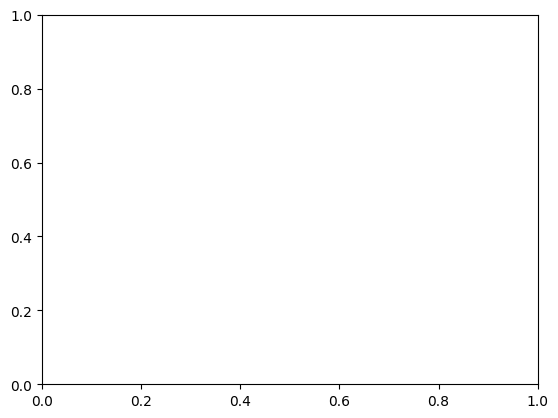

In [14]:
ale_plot(model_forest_fig, train_set=x_test, monte_carlo=True, rugplot_lim=None, features=['Retainedearn_ratio'],)
plt.ylabel('股利支付率',fontsize = 13)
plt.xlabel('留存收益资产比',fontsize = 13)
plt.title('ALE图-随机森林',fontsize = 13)
plt.tick_params(labelsize=13)
plt.subplots_adjust(left=0.15,bottom = 0.15)
# ax=plt.gca() 
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.yaxis.grid(linewidth=0.1,color='black',linestyle='--')
# ax.tick_params(bottom=False,top=False,left=False,right=False)
plt.savefig(FIG_DIR / 'retainearned-forest.png', dpi=200)

TypeError: quantile() got an unexpected keyword argument 'interpolation'

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


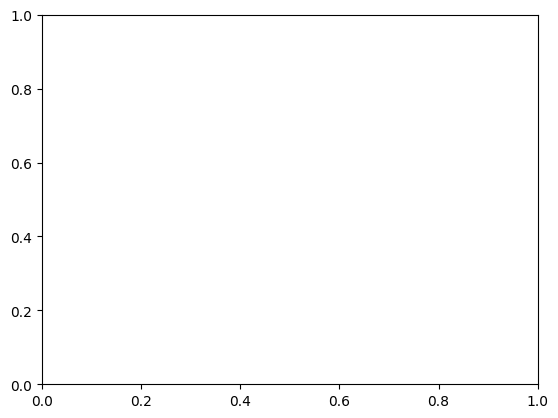

In [15]:
ale_plot(model_forest_fig, train_set=x_test, monte_carlo=True, rugplot_lim=None, features=['Tax_ratio'],)
plt.ylabel('股利支付率',fontsize = 13)
plt.xlabel('实际税率',fontsize = 13)
plt.title('ALE图-随机森林',fontsize = 13)
plt.tick_params(labelsize=13)
plt.subplots_adjust(left=0.15,bottom = 0.15)
# ax=plt.gca() 
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.yaxis.grid(linewidth=0.1,color='black',linestyle='--')
# ax.tick_params(bottom=False,top=False,left=False,right=False)
plt.savefig(FIG_DIR / 'taxratio-forest.png', dpi=200)

TypeError: quantile() got an unexpected keyword argument 'interpolation'

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


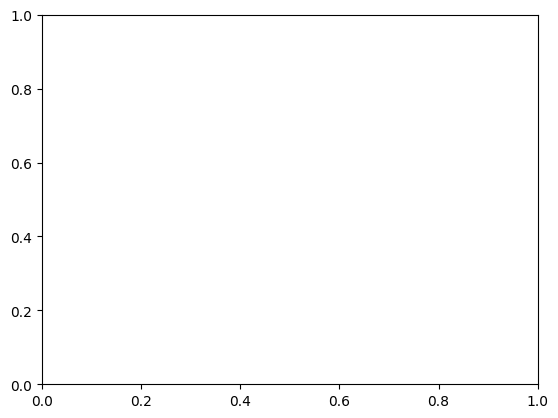

In [16]:
ale_plot(model_forest_fig, train_set=x_test, monte_carlo=True, rugplot_lim=None, features=['Tax_volatility'],)
plt.ylabel('股利支付率',fontsize = 13)
plt.xlabel('纳税波动性',fontsize = 13)
plt.title('ALE图-随机森林',fontsize = 13)
plt.tick_params(labelsize=13)
plt.subplots_adjust(left=0.15,bottom = 0.15)
# ax=plt.gca() 
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.yaxis.grid(linewidth=0.1,color='black',linestyle='--')
# ax.tick_params(bottom=False,top=False,left=False,right=False)
plt.savefig(FIG_DIR / 'taxvol-forest.png', dpi=200)

TypeError: quantile() got an unexpected keyword argument 'interpolation'

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


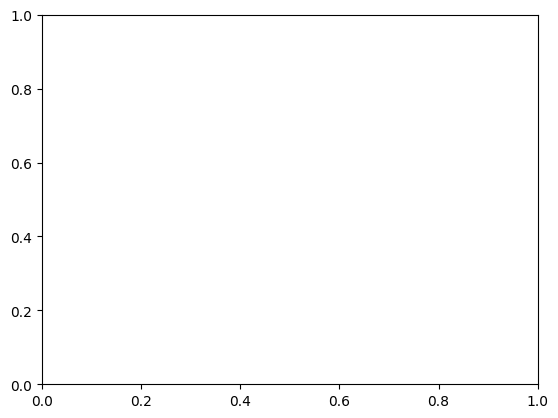

In [17]:
ale_plot(model_forest_fig, train_set=x_test, monte_carlo=True, rugplot_lim=None, features=['Tunneling'],)
plt.ylabel('股利支付率',fontsize = 13)
plt.xlabel('其他应收款资产比',fontsize = 13)
plt.title('ALE图-随机森林',fontsize = 13)
plt.tick_params(labelsize=13)
plt.subplots_adjust(left=0.15,bottom = 0.15)
# ax=plt.gca() 
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.yaxis.grid(linewidth=0.1,color='black',linestyle='--')
# ax.tick_params(bottom=False,top=False,left=False,right=False)
plt.savefig(FIG_DIR / 'tunneling-forest.png', dpi=200)

TypeError: quantile() got an unexpected keyword argument 'interpolation'

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


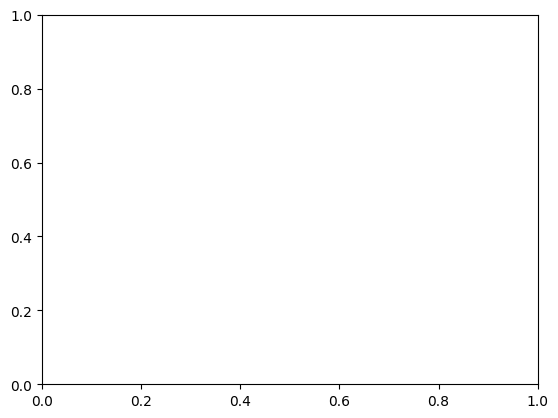

In [18]:
ale_plot(model_forest_fig, train_set=x_test, monte_carlo=True, rugplot_lim=None, features=['Constraint'],)
plt.ylabel('股利支付率',fontsize = 13)
plt.xlabel('融资约束程度',fontsize = 13)
plt.title('ALE图-随机森林',fontsize = 13)
plt.tick_params(labelsize=13)
plt.subplots_adjust(left=0.15,bottom = 0.15)
# ax=plt.gca() 
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.yaxis.grid(linewidth=0.1,color='black',linestyle='--')
# ax.tick_params(bottom=False,top=False,left=False,right=False)
plt.savefig(FIG_DIR / 'Constraint-forest.png', dpi=200)

TypeError: quantile() got an unexpected keyword argument 'interpolation'

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


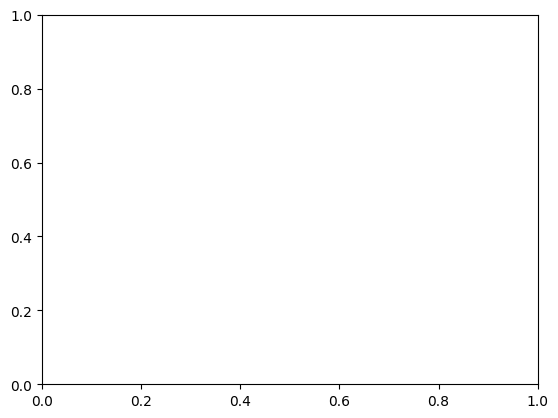

In [19]:
ale_plot(model_forest_fig, train_set=x_test, monte_carlo=True, rugplot_lim=None, features=['Dividend_lag'],)
plt.ylabel('股利支付率',fontsize = 13)
plt.xlabel('上一期股利支付水平',fontsize = 13)
plt.title('ALE图-随机森林',fontsize = 13)
plt.tick_params(labelsize=13)
plt.subplots_adjust(left=0.15,bottom = 0.15)
# ax=plt.gca() 
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.yaxis.grid(linewidth=0.1,color='black',linestyle='--')
# ax.tick_params(bottom=False,top=False,left=False,right=False)
plt.savefig(FIG_DIR / 'Dividend_lag-forest.png', dpi=200)

TypeError: quantile() got an unexpected keyword argument 'interpolation'

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


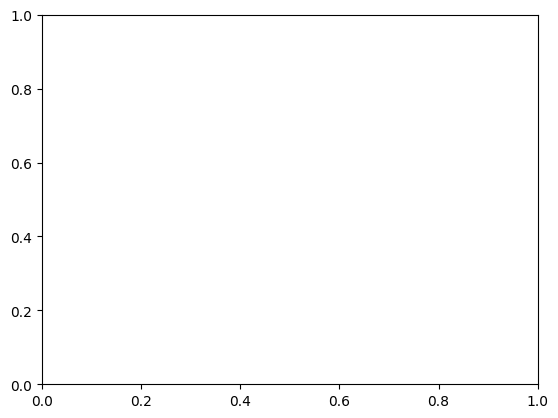

In [20]:
ale_plot(model_gbr_fig, train_set=x_test, monte_carlo=True, rugplot_lim=None, features=['Retainedearn_ratio'],)
plt.ylabel('股利支付率',fontsize = 13)
plt.xlabel('留存收益资产比',fontsize = 13)
plt.title('ALE图-渐进梯度回归树',fontsize = 13)
plt.tick_params(labelsize=13)
plt.subplots_adjust(left=0.15,bottom = 0.15)
# ax=plt.gca() 
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.yaxis.grid(linewidth=0.1,color='black',linestyle='--')
# ax.tick_params(bottom=False,top=False,left=False,right=False)
plt.savefig(FIG_DIR / 'retainearned.png', dpi=200)

TypeError: quantile() got an unexpected keyword argument 'interpolation'

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


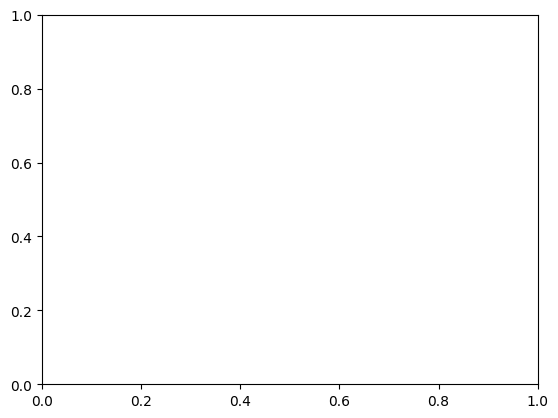

In [21]:
ale_plot(model_gbr_fig, train_set=x_test, monte_carlo=True, rugplot_lim=None, features=['Tax_ratio'],)
plt.ylabel('股利支付率',fontsize = 13)
plt.xlabel('实际税率',fontsize = 13)
plt.title('ALE图-渐进梯度回归树',fontsize = 13)
plt.tick_params(labelsize=13)
plt.subplots_adjust(left=0.15,bottom = 0.15)
# ax=plt.gca() 
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.yaxis.grid(linewidth=0.1,color='black',linestyle='--')
# ax.tick_params(bottom=False,top=False,left=False,right=False)
plt.savefig(FIG_DIR / 'taxratio.png', dpi=200)

TypeError: quantile() got an unexpected keyword argument 'interpolation'

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


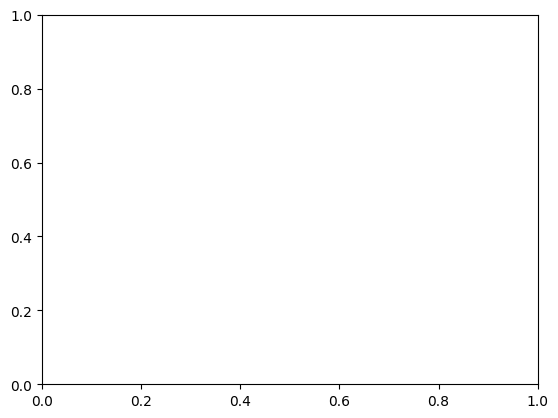

In [22]:
ale_plot(model_gbr_fig, train_set=x_test, monte_carlo=True, rugplot_lim=None, features=['Tax_volatility'],)
plt.ylabel('股利支付率',fontsize = 13)
plt.xlabel('纳税波动性',fontsize = 13)
plt.title('ALE图-渐进梯度回归树',fontsize = 13)
plt.tick_params(labelsize=13)
plt.subplots_adjust(left=0.15,bottom = 0.15)
# ax=plt.gca() 
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.yaxis.grid(linewidth=0.1,color='black',linestyle='--')
# ax.tick_params(bottom=False,top=False,left=False,right=False)
plt.savefig(FIG_DIR / 'taxvol.png', dpi=200)

TypeError: quantile() got an unexpected keyword argument 'interpolation'

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


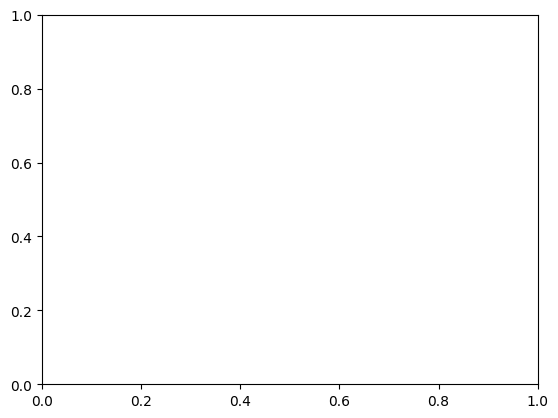

In [23]:
ale_plot(model_gbr_fig, train_set=x_test, monte_carlo=True, rugplot_lim=None, features=['Tunneling'],)
plt.ylabel('股利支付率',fontsize = 13)
plt.xlabel('其他应收款资产比',fontsize = 13)
plt.title('ALE图-渐进梯度回归树',fontsize = 13)
plt.tick_params(labelsize=13)
plt.subplots_adjust(left=0.15,bottom = 0.15)
# ax=plt.gca() 
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.yaxis.grid(linewidth=0.1,color='black',linestyle='--')
# ax.tick_params(bottom=False,top=False,left=False,right=False)
plt.savefig(FIG_DIR / 'tunneling.png', dpi=200)

TypeError: quantile() got an unexpected keyword argument 'interpolation'

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


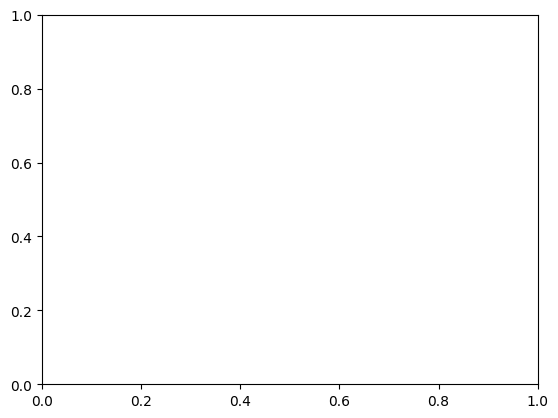

In [24]:
ale_plot(model_gbr_fig, train_set=x_test, monte_carlo=True, rugplot_lim=None, features=['Constraint'],)
plt.ylabel('股利支付率',fontsize = 13)
plt.xlabel('融资约束程度',fontsize = 13)
plt.title('ALE图-渐进梯度回归树',fontsize = 13)
plt.tick_params(labelsize=13)
plt.subplots_adjust(left=0.15,bottom = 0.15)
# ax=plt.gca() 
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.yaxis.grid(linewidth=0.1,color='black',linestyle='--')
# ax.tick_params(bottom=False,top=False,left=False,right=False)
plt.savefig(FIG_DIR / 'Constraint.png', dpi=200)

TypeError: quantile() got an unexpected keyword argument 'interpolation'

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


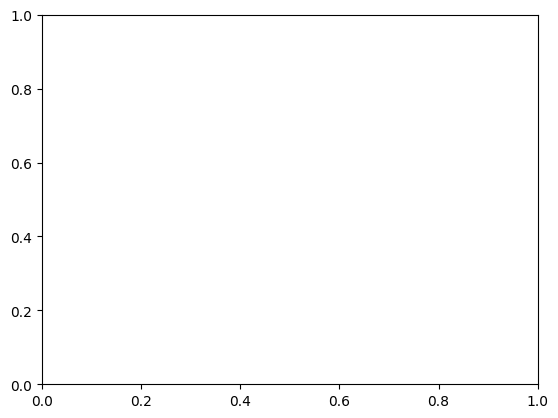

In [25]:
ale_plot(model_gbr_fig, train_set=x_test, monte_carlo=True, rugplot_lim=None, features=['Dividend_lag'],)
plt.ylabel('股利支付率',fontsize = 13)
plt.xlabel('上一期股利支付水平',fontsize = 13)
plt.title('ALE图-渐进梯度回归树',fontsize = 13)
plt.tick_params(labelsize=13)
plt.subplots_adjust(left=0.15,bottom = 0.15)
# ax=plt.gca() 
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.yaxis.grid(linewidth=0.1,color='black',linestyle='--')
# ax.tick_params(bottom=False,top=False,left=False,right=False)
plt.savefig(FIG_DIR / 'Dividend_lag.png', dpi=200)

In [26]:
###### 数据导入
data = pd.read_csv(DATA_DIR / 'dataqian.csv', header=0)
data = pd.DataFrame(data)
print(data.head(3))
print(data.shape)

   Stkcd  year  Dividend_ratio1  Dividend_ratio2  Dividend_ratio3  Dividend  \
0      2  2006         0.304220         1.351294         0.971503         1   
1      6  2006         0.410430         3.040745         2.609993         1   
2      6  2007         0.098394         0.455409         0.382409         1   

   Managefee_ratio  Manageshare  Indep_ratio   Bgender  ...  ind32  ind33  \
0         0.047734       0.0292     0.363636  0.181818  ...      0      0   
1         0.069533       1.5881     0.333333  0.333333  ...      0      0   
2         0.073536       1.5881     0.333333  0.333333  ...      0      0   

   ind34  ind35  ind37  ind38  ind39  ind40  ind41  ind42  
0      0      0      0      1      0      0      0      0  
1      0      0      0      1      0      0      0      0  
2      0      0      0      1      0      0      0      0  

[3 rows x 77 columns]
(5722, 77)


In [27]:
###### 数据预处理
x = data.iloc[:, 6:]
y = data.iloc[:, 2] #股利分配率
# y = data.iloc[:, 1] #是否发放股利

x_train1 = x.loc[data['year']==2008]
y_train1 = y.loc[data['year']==2008]
sc = StandardScaler()
sc.fit(x_train1)
x_train1 = sc.transform(x_train1)
x_train1 = pd.DataFrame(x_train1,columns= x.columns)

for i in range(2,5):
    exec ("x_train%s=1"%i)
    exec ("y_train%s=1"%i)

x_train = [x_train1,x_train2,x_train3,x_train4]
y_train = [y_train1,y_train2,y_train3,y_train4]

for i in range(1,5):
    j = i + 2007
    k = i - 1
    x_train[k] = x.loc[data['year']== j]
    y_train[k] = y.loc[data['year']== j]
    x_train[k] = sc.transform(x_train[k])
    x_train[k] = pd.DataFrame(x_train[k],columns= x.columns)

In [28]:
x_test = sc.transform(x)
x_test = pd.DataFrame(x_test,columns= x.columns)

names = list(x_train1.columns)

In [29]:
model_gbr_fig = GradientBoostingRegressor(n_estimators =3000 , max_depth = 4,subsample = 0.7,learning_rate = 0.001,random_state=0)
model_gbr_fig.fit(x_test,y)

,"loss loss: {'squared_error', 'absolute_error', 'huber', 'quantile'}, default='squared_error'Loss function to be optimized. 'squared_error' refers to the squarederror for regression. 'absolute_error' refers to the absolute error ofregression and is a robust loss function. 'huber' is acombination of the two. 'quantile' allows quantile regression (use`alpha` to specify the quantile).See:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_quantile.py`for an example that demonstrates quantile regression for creatingprediction intervals with `loss='quantile'`.",'squared_error'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.",0.001
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",3000
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",0.7
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are""friedman_mse"" for the mean squared error with improvement score byFriedman, ""squared_error"" for mean squared error. The default value of""friedman_mse"" is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",4
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in thele

In [30]:
model_forest_fig = RandomForestRegressor(n_estimators=5000, max_features=10,random_state=0, n_jobs=-1)
model_forest_fig.fit(x_train1,y_train1)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",5000
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",10
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

TypeError: quantile() got an unexpected keyword argument 'interpolation'

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


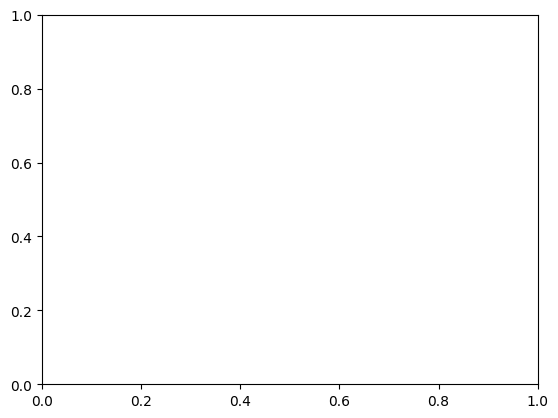

In [31]:
ale_plot(model_gbr_fig, train_set=x_test, monte_carlo=True, rugplot_lim=None, features=['Institution'],)
plt.ylabel('股利支付率',fontsize = 13)
plt.xlabel('机构投资者持股比例',fontsize = 13)
plt.title('ALE图-渐进梯度回归树',fontsize = 13)
plt.tick_params(labelsize=13)
plt.subplots_adjust(left=0.15,bottom = 0.15)
ax=plt.gca() 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.grid(linewidth=0.1,color='black',linestyle='--')
ax.tick_params(bottom=False,top=False,left=False,right=False)
plt.savefig(RESULT_DIR / 'institution-gbr.png', dpi=200)

TypeError: quantile() got an unexpected keyword argument 'interpolation'

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


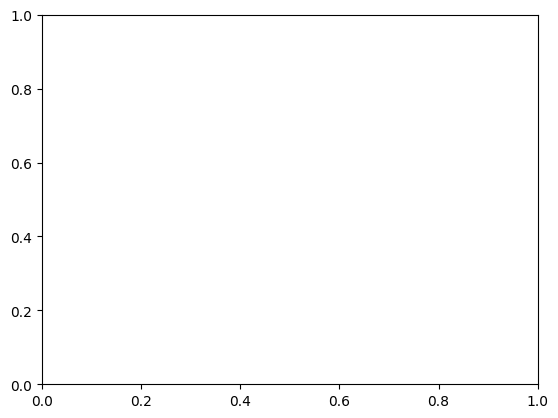

In [32]:
ale_plot(model_forest_fig, train_set=x_test, monte_carlo=True, rugplot_lim=None, features=['Institution'],)
plt.ylabel('股利支付率',fontsize = 13)
plt.xlabel('机构投资者持股比例',fontsize = 13)
plt.title('ALE图-随机森林',fontsize = 13)
plt.tick_params(labelsize=13)
plt.subplots_adjust(left=0.15,bottom = 0.15)
ax=plt.gca() 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.grid(linewidth=0.1,color='black',linestyle='--')
ax.tick_params(bottom=False,top=False,left=False,right=False)
plt.savefig(RESULT_DIR / 'institution-forest.png', dpi=200)

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


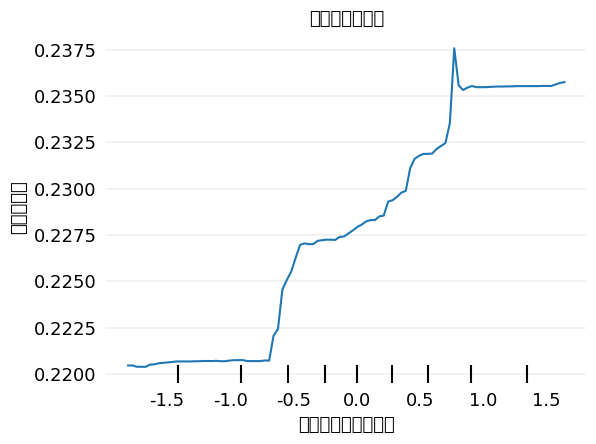

In [33]:
plt.rcParams['font.sans-serif']=['Times New Roman'] #用来正常显示中文标签
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
PartialDependenceDisplay.from_estimator(model_gbr_fig,x_test,['Institution'],grid_resolution=100,n_jobs = -1,method = 'brute')
plt.ylabel('股利支付率',fontsize = 13)
plt.xlabel('机构投资者持股比例',fontsize = 13)
plt.title('渐进梯度回归树',fontsize = 13) 
plt.tick_params(labelsize=13)
plt.subplots_adjust(left=0.15,bottom = 0.15)
ax=plt.gca() 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.grid(linewidth=0.1,color='black',linestyle='--')
ax.tick_params(bottom=False,top=False,left=False,right=False)
plt.savefig(RESULT_DIR / 'institution-gbr-part.png', dpi=200)

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


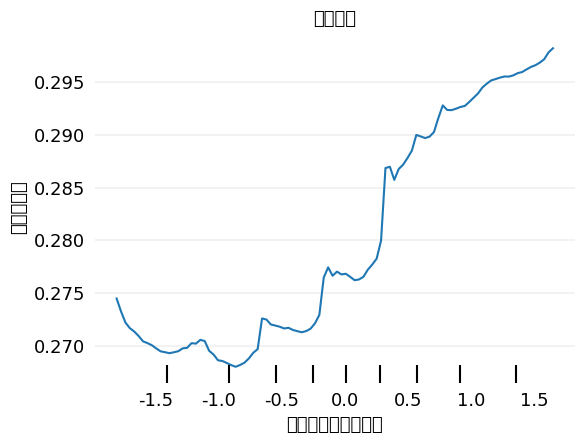

In [34]:
plt.rcParams['font.sans-serif']=['Times New Roman'] #用来正常显示中文标签
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
PartialDependenceDisplay.from_estimator(model_forest_fig,x_test,['Institution'],grid_resolution=100,n_jobs = -1,method = 'brute')
plt.ylabel('股利支付率',fontsize = 13)
plt.xlabel('机构投资者持股比例',fontsize = 13)
plt.title('随机森林',fontsize = 13) 
plt.tick_params(labelsize=13)
plt.subplots_adjust(left=0.15,bottom = 0.15)
ax=plt.gca() 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.grid(linewidth=0.1,color='black',linestyle='--')
ax.tick_params(bottom=False,top=False,left=False,right=False)
plt.savefig(RESULT_DIR / 'institution-forest-part.png', dpi=200)

In [35]:
###### 数据导入
data = pd.read_csv(DATA_DIR / 'datan-bigcash.csv', header=0)
data = pd.DataFrame(data)
print(data.head(3))
print(data.shape)

    Stkcd  year  Dividend_ratio1  Dividend_ratio2  Dividend_ratio3  Dividend  \
0     829  2006         0.178495         0.537521         0.476190         1   
1     972  2006         0.095139         0.162399         0.234192         1   
2  600075  2006         0.000000         0.000000         0.000000         0   

   Managefee_ratio  Manageshare  Indep_ratio   Bgender  ...  ind32  ind33  \
0         0.013195       0.0083     0.363636  0.000000  ...      0      0   
1         0.042730       0.0012     0.333333  0.111111  ...      0      0   
2         0.031275       0.0346     0.333333  0.000000  ...      0      0   

   ind34  ind35  ind37  ind38  ind39  ind40  ind41  ind42  
0      0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0      0  

[3 rows x 77 columns]
(15588, 77)


In [36]:
###### 数据预处理
x = data.iloc[:, 6:]
# x = data.iloc[:, 6:38]
y = data.iloc[:, 2] #股利分配率
# y = data.iloc[:, 1] #是否发放股利

x_train1 = x.loc[data['year']==2006]
y_train1 = y.loc[data['year']==2006]
sc = StandardScaler()
sc.fit(x_train1)
x_train1 = sc.transform(x_train1)
x_train1 = pd.DataFrame(x_train1,columns= x.columns)

for i in range(2,18):
    exec ("x_train%s=1"%i)
    exec ("y_train%s=1"%i)

x_train = [x_train1,x_train2,x_train3,x_train4,x_train5,x_train6,x_train7,x_train8,x_train9,x_train10,x_train11,x_train12,x_train13,
           x_train14,x_train15,x_train16,x_train17]
y_train = [y_train1,y_train2,y_train3,y_train4,y_train5,y_train6,y_train7,y_train8,y_train9,y_train10,y_train11,y_train12,y_train13,
          y_train14,y_train15,y_train16,y_train17]

for i in range(1,18):
    j = i + 2005
    k = i - 1
    x_train[k] = x.loc[data['year']== j]
    y_train[k] = y.loc[data['year']== j]
    x_train[k] = sc.transform(x_train[k])
    x_train[k] = pd.DataFrame(x_train[k],columns= x.columns)

In [37]:
x_test = sc.transform(x)
x_test = pd.DataFrame(x_test,columns= x.columns)

names = list(x_train1.columns)

In [38]:
# model_gbr_fig = GradientBoostingRegressor(n_estimators =3000 , max_depth = 4,subsample = 0.7,learning_rate = 0.001,random_state=0)
model_gbr_fig = GradientBoostingRegressor(n_estimators =5000 , max_depth = 6,subsample = 0.8,learning_rate = 0.001,random_state=0)
model_gbr_fig.fit(x_test,y)

,"loss loss: {'squared_error', 'absolute_error', 'huber', 'quantile'}, default='squared_error'Loss function to be optimized. 'squared_error' refers to the squarederror for regression. 'absolute_error' refers to the absolute error ofregression and is a robust loss function. 'huber' is acombination of the two. 'quantile' allows quantile regression (use`alpha` to specify the quantile).See:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_quantile.py`for an example that demonstrates quantile regression for creatingprediction intervals with `loss='quantile'`.",'squared_error'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.",0.001
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",5000
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",0.8
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are""friedman_mse"" for the mean squared error with improvement score byFriedman, ""squared_error"" for mean squared error. The default value of""friedman_mse"" is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",6
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in thele

In [39]:
model_forest_fig = RandomForestRegressor(n_estimators=5000, max_features=10,random_state=0, n_jobs=-1)
model_forest_fig.fit(x_test,y)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",5000
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",10
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

TypeError: quantile() got an unexpected keyword argument 'interpolation'

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


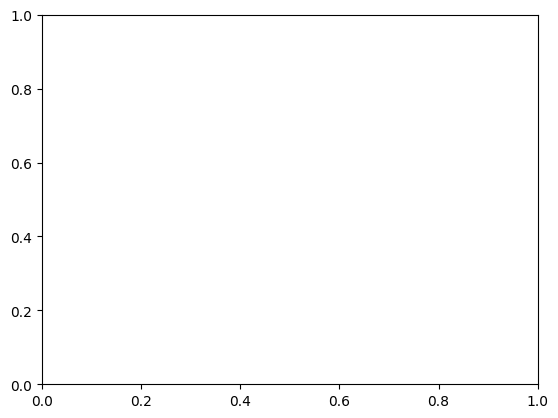

In [40]:
ale_plot(model_gbr_fig, train_set=x_test, monte_carlo=True, rugplot_lim=None, features=['Freecash2'],)
plt.ylabel('股利支付率',fontsize = 13)
plt.xlabel('自由现金流',fontsize = 13)
plt.title('ALE图-渐进梯度回归树',fontsize = 13)
plt.tick_params(labelsize=13)
plt.subplots_adjust(left=0.15,bottom = 0.15)
ax=plt.gca() 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.grid(linewidth=0.1,color='black',linestyle='--')
ax.tick_params(bottom=False,top=False,left=False,right=False)
plt.savefig(RESULT_DIR / 'cash-freecash-gbr.png', dpi=200)

TypeError: quantile() got an unexpected keyword argument 'interpolation'

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


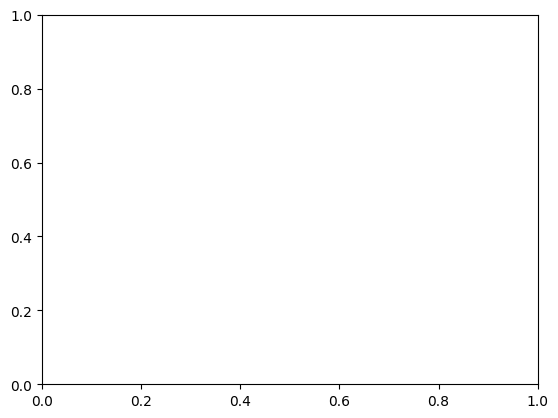

In [41]:
ale_plot(model_forest_fig, train_set=x_test, monte_carlo=True, rugplot_lim=None, features=['Freecash2'],)
plt.ylabel('股利支付率',fontsize = 13)
plt.xlabel('自由现金流',fontsize = 13)
plt.title('ALE图-随机森林',fontsize = 13)
plt.tick_params(labelsize=13)
plt.subplots_adjust(left=0.15,bottom = 0.15)
ax=plt.gca() 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.grid(linewidth=0.1,color='black',linestyle='--')
ax.tick_params(bottom=False,top=False,left=False,right=False)
plt.savefig(RESULT_DIR / 'cash-freecas-forest.png', dpi=200)

In [42]:
###### 数据导入
data = pd.read_csv(DATA_DIR / 'data-guliup.csv', header=0)
data = pd.DataFrame(data)
print(data.head(3))
print(data.shape)

   Stkcd  year  Dividend_ratio1  Dividend_ratio2  Dividend_ratio3  Dividend  \
0      2  2013         0.298716         0.942424         5.105866         1   
1      2  2017         0.354175         0.852556         2.897618         1   
2      4  2012         0.000000         0.000000         0.000000         0   

   Managefee_ratio  Manageshare  Indep_ratio   Bgender  ...  ind32  ind33  \
0         0.022174       0.2884     0.363636  0.181818  ...      0      0   
1         0.036500       0.1090     0.363636  0.090909  ...      0      0   
2         0.175151       0.0027     0.333333  0.111111  ...      0      0   

   ind34  ind35  ind37  ind38  ind39  ind40  ind41  ind42  
0      0      0      0      1      0      0      0      0  
1      0      0      0      1      0      0      0      0  
2      0      0      0      0      0      0      0      0  

[3 rows x 77 columns]
(12185, 77)


In [43]:
###### 数据预处理
x = data.iloc[:, 6:]
y = data.iloc[:, 2] #股利分配率
# y = data.iloc[:, 1] #是否发放股利

x_train1 = x.loc[data['year']==2007]
y_train1 = y.loc[data['year']==2007]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30,
                                                    random_state=0)  # 划分训练集、测试集,未分年度，按y的分布混合抽样
sc = StandardScaler()
sc.fit(x_train)
x_train = sc.transform(x_train) #训练集特征标准化
x_test = sc.transform(x_test) #测试集特征标准化，使用训练集的参数进行变换，即测试集的变化与训练集保持一致
x_train = pd.DataFrame(x_train,columns=x.columns)
x_test = pd.DataFrame(x_test,columns=x.columns)
names = list(x_train.columns)


In [44]:
model_gbr_fig = GradientBoostingRegressor(n_estimators =3000 , max_depth = 4,subsample = 0.7,learning_rate = 0.001,random_state=0)
model_gbr_fig.fit(x_train,y_train)

,"loss loss: {'squared_error', 'absolute_error', 'huber', 'quantile'}, default='squared_error'Loss function to be optimized. 'squared_error' refers to the squarederror for regression. 'absolute_error' refers to the absolute error ofregression and is a robust loss function. 'huber' is acombination of the two. 'quantile' allows quantile regression (use`alpha` to specify the quantile).See:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_quantile.py`for an example that demonstrates quantile regression for creatingprediction intervals with `loss='quantile'`.",'squared_error'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.",0.001
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",3000
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",0.7
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are""friedman_mse"" for the mean squared error with improvement score byFriedman, ""squared_error"" for mean squared error. The default value of""friedman_mse"" is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",4
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in thele

In [45]:
model_forest_fig = RandomForestRegressor(n_estimators=5000, max_features=19,random_state=0, n_jobs=-1)
model_forest_fig.fit(x_train,y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",5000
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",19
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

TypeError: quantile() got an unexpected keyword argument 'interpolation'

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


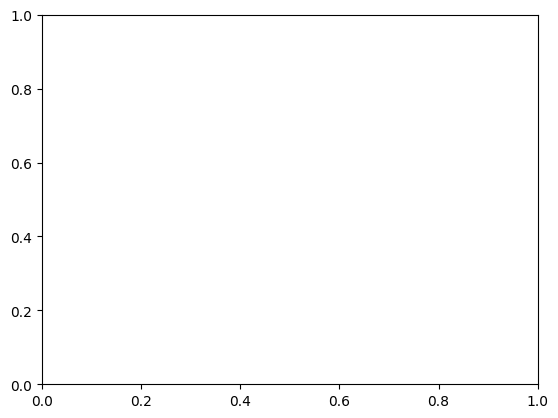

In [46]:
ale_plot(model_gbr_fig, train_set=x_train, monte_carlo=True, rugplot_lim=None, features=['Tunneling'],)
plt.ylabel('股利支付率',fontsize = 13)
plt.xlabel('其他应收款资产比',fontsize = 13)
plt.title('ALE图-渐进梯度回归树',fontsize = 13)
plt.tick_params(labelsize=13)
plt.subplots_adjust(left=0.15,bottom = 0.15)
ax=plt.gca() 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.grid(linewidth=0.1,color='black',linestyle='--')
ax.tick_params(bottom=False,top=False,left=False,right=False)
plt.savefig(RESULT_DIR / 'tunneling-gbr-up.png', dpi=200)

TypeError: quantile() got an unexpected keyword argument 'interpolation'

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


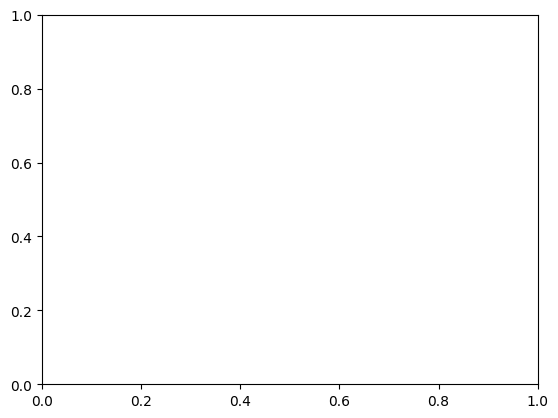

In [47]:
ale_plot(model_forest_fig, train_set=x_train, monte_carlo=True, rugplot_lim=None, features=['Tunneling'],)
plt.ylabel('股利支付率',fontsize = 13)
plt.xlabel('其他应收款资产比',fontsize = 13)
plt.title('ALE图-随机森林',fontsize = 13)
plt.tick_params(labelsize=13)
plt.subplots_adjust(left=0.15,bottom = 0.15)
ax=plt.gca() 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.grid(linewidth=0.1,color='black',linestyle='--')
ax.tick_params(bottom=False,top=False,left=False,right=False)
plt.savefig(RESULT_DIR / 'tunneling-forest-up.png', dpi=200)

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


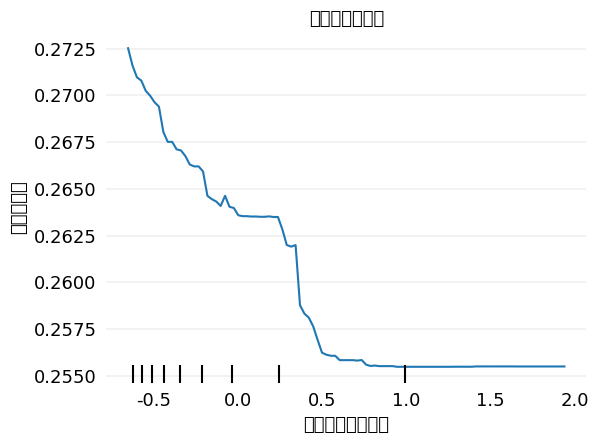

In [48]:
plt.rcParams['font.sans-serif']=['Times New Roman'] #用来正常显示中文标签
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
PartialDependenceDisplay.from_estimator(model_gbr_fig,x_train,['Tunneling'],grid_resolution=100,n_jobs = -1,method = 'brute')
plt.ylabel('股利支付率',fontsize = 13)
plt.xlabel('其他应收款资产比',fontsize = 13)
plt.title('渐进梯度回归树',fontsize = 13) 
plt.tick_params(labelsize=13)
plt.subplots_adjust(left=0.15,bottom = 0.15)
ax=plt.gca() 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.grid(linewidth=0.1,color='black',linestyle='--')
ax.tick_params(bottom=False,top=False,left=False,right=False)
plt.savefig(RESULT_DIR / 'tunnelin-gbr-part.png', dpi=200)

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


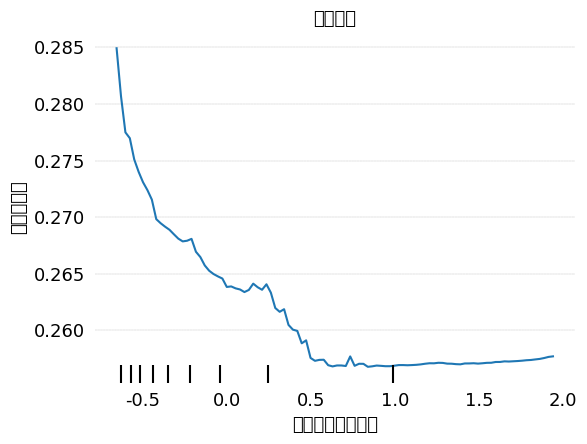

In [49]:
plt.rcParams['font.sans-serif']=['Times New Roman'] #用来正常显示中文标签
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
PartialDependenceDisplay.from_estimator(model_forest_fig,x_train,['Tunneling'],grid_resolution=100,n_jobs = -1,method = 'brute')
plt.ylabel('股利支付率',fontsize = 13)
plt.xlabel('其他应收款资产比',fontsize = 13)
plt.title('随机森林',fontsize = 13) 
plt.tick_params(labelsize=13)
plt.subplots_adjust(left=0.15,bottom = 0.15)
ax=plt.gca() 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.grid(linewidth=0.1,color='black',linestyle='--')
ax.tick_params(bottom=False,top=False,left=False,right=False)
plt.savefig(RESULT_DIR / 'tunneling-forest-part.png', dpi=200)

In [50]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error,median_absolute_error,explained_variance_score
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV,KFold,StratifiedKFold,RandomizedSearchCV #交叉验证
from sklearn.preprocessing import StandardScaler #特征标准化
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay #部分依赖图
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split  # 划分训练集、验证集、测试集
from sklearn.svm import SVR #支持向量机
from sklearn.neural_network import MLPRegressor #神经网络
from sklearn.tree import DecisionTreeRegressor #决策树
from sklearn.svm import SVR #支持向量机
# from xgboost.sklearn import XGBRegressor

from sklearn.linear_model import LogisticRegression #Logit
from sklearn.tree import DecisionTreeClassifier #决策树
from sklearn.svm import SVC #支持向量机
from sklearn.ensemble import RandomForestClassifier #随机森林
from sklearn.ensemble import GradientBoostingClassifier #梯度提升树
# from xgboost.sklearn import XGBClassifier #XGBoost
from sklearn.neural_network import MLPClassifier #神经网络
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV #交叉验证
from sklearn.model_selection import train_test_split  # 划分训练集、验证集、测试集
from sklearn.preprocessing import StandardScaler #特征标准化
from sklearn.metrics import roc_curve, auc,RocCurveDisplay  # ROC曲线，计算AUC
from sklearn.inspection import PartialDependenceDisplay #部分依赖图
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import average_precision_score
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error,median_absolute_error,explained_variance_score
import time
import random
from sklearn.metrics import fbeta_score

In [51]:
###### 数据导入
data = pd.read_csv(DATA_DIR / 'data.csv', header=0)
data = pd.DataFrame(data)
print(data.head(3))
print(data.shape)

   Stkcd  year  Dividend_ratio1  Dividend_ratio2  Dividend_ratio3  Dividend  \
0      2  2006         0.304220         1.351294         0.971503         1   
1      2  2013         0.298716         0.942424         5.105866         1   
2      2  2014         0.350498         1.085495         3.597122         1   

   Managefee_ratio  Manageshare  Indep_ratio   Bgender  ...  ind32  ind33  \
0         0.047734       0.0292     0.363636  0.181818  ...      0      0   
1         0.022174       0.2884     0.363636  0.181818  ...      0      0   
2         0.026659       0.1815     0.363636  0.090909  ...      0      0   

   ind34  ind35  ind37  ind38  ind39  ind40  ind41  ind42  
0      0      0      0      1      0      0      0      0  
1      0      0      0      1      0      0      0      0  
2      0      0      0      1      0      0      0      0  

[3 rows x 77 columns]
(31469, 77)


In [52]:
###### 数据预处理
x = data.iloc[:, 6:]
y = data.iloc[:, 5] #是否发放股利

x_train1 = x.loc[data['year']==2006]
y_train1 = y.loc[data['year']==2006]
sc = StandardScaler()
sc.fit(x_train1)
x_train1 = sc.transform(x_train1)
x_train1 = pd.DataFrame(x_train1,columns= x.columns)

for i in range(2,18):
    exec ("x_train%s=1"%i)
    exec ("y_train%s=1"%i)

x_train = [x_train1,x_train2,x_train3,x_train4,x_train5,x_train6,x_train7,x_train8,x_train9,x_train10,x_train11,x_train12,x_train13,
           x_train14,x_train15,x_train16,x_train17]
y_train = [y_train1,y_train2,y_train3,y_train4,y_train5,y_train6,y_train7,y_train8,y_train9,y_train10,y_train11,y_train12,y_train13,
          y_train14,y_train15,y_train16,y_train17]

for i in range(1,18):
    j = i + 2005
    k = i - 1
    x_train[k] = x.loc[data['year']== j]
    y_train[k] = y.loc[data['year']== j]
    x_train[k] = sc.transform(x_train[k])
    x_train[k] = pd.DataFrame(x_train[k],columns= x.columns)

In [53]:
x_test = sc.transform(x)
x_test = pd.DataFrame(x_test,columns= x.columns)

names = list(x_train1.columns)

In [54]:
model_gbr_fig = GradientBoostingClassifier(n_estimators =1000 , max_depth = 2,subsample = 0.2,learning_rate = 0.01,random_state=0)
model_gbr_fig.fit(x_test,y)

,"loss loss: {'log_loss', 'exponential'}, default='log_loss'The loss function to be optimized. 'log_loss' refers to binomial andmultinomial deviance, the same as used in logistic regression.It is a good choice for classification with probabilistic outputs.For loss 'exponential', gradient boosting recovers the AdaBoost algorithm.",'log_loss'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.For an example of the effects of this parameter and its interaction with``subsample``, see:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_regularization.py`.",0.01
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",1000
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",0.2
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are'friedman_mse' for the mean squared error with improvement score byFriedman, 'squared_error' for mean squared error. The default value of'friedman_mse' is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",2
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``

In [55]:
model_forest_fig = RandomForestClassifier(n_estimators=2000, max_features=20,random_state=0, n_jobs=-1)
model_forest_fig.fit(x_test,y)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",2000
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",20
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y_

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


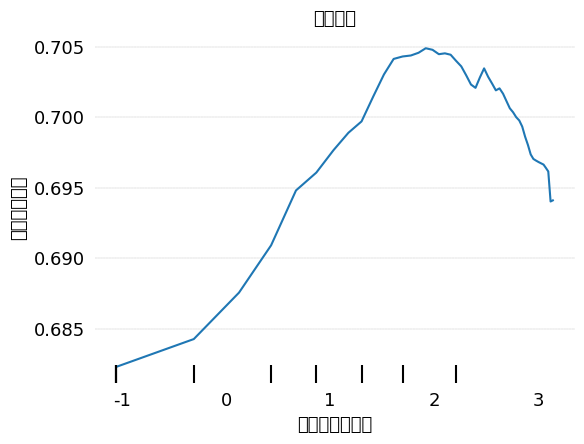

In [56]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
PartialDependenceDisplay.from_estimator(model_forest_fig,x_test,['Analyst_num'],grid_resolution=100,method = 'brute')
plt.ylabel('股利支付意愿',fontsize = 13)
plt.xlabel('分析师跟踪人数',fontsize = 13)
plt.title('随机森林',fontsize = 13)
plt.tick_params(labelsize=13)
plt.subplots_adjust(left=0.15,bottom = 0.15)
ax=plt.gca() 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.grid(linewidth=0.1,color='black',linestyle='--')
ax.tick_params(bottom=False,top=False,left=False,right=False)
plt.savefig(RESULT_DIR / '分析师跟踪人数1.png', dpi=200)

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


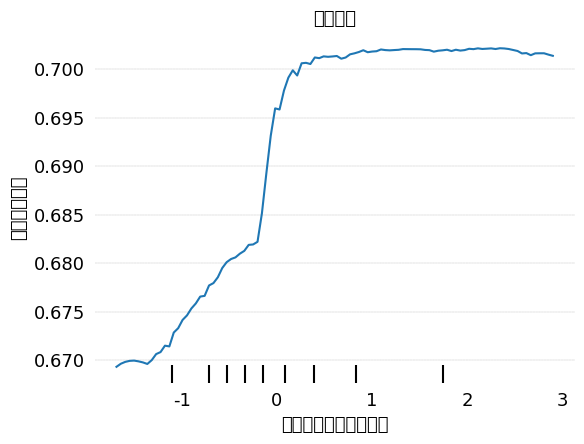

In [57]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
PartialDependenceDisplay.from_estimator(model_forest_fig,x_test,['Cashflow'],grid_resolution=100,method = 'brute')
plt.ylabel('股利支付意愿',fontsize = 13)
plt.xlabel('每股经营活动现金流量',fontsize = 13)
plt.title('随机森林',fontsize = 13)
plt.tick_params(labelsize=13)
plt.subplots_adjust(left=0.15,bottom = 0.15)
ax=plt.gca() 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.grid(linewidth=0.1,color='black',linestyle='--')
ax.tick_params(bottom=False,top=False,left=False,right=False)
plt.savefig(RESULT_DIR / '每股经营活动现金流量1.png', dpi=200)

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


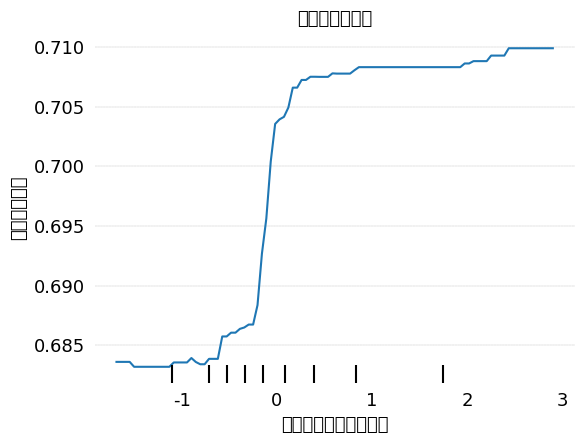

In [58]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
PartialDependenceDisplay.from_estimator(model_gbr_fig,x_test,['Cashflow'],grid_resolution=100,n_jobs = -1,method = 'brute')
plt.ylabel('股利支付意愿',fontsize = 13)
plt.xlabel('每股经营活动现金流量',fontsize = 13)
plt.title('渐进梯度分类树',fontsize = 13)
plt.tick_params(labelsize=13)
plt.subplots_adjust(left=0.15,bottom = 0.15)
ax=plt.gca() 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.grid(linewidth=0.1,color='black',linestyle='--')
ax.tick_params(bottom=False,top=False,left=False,right=False)
plt.savefig(RESULT_DIR / '每股经营活动现金流量.png', dpi=200)

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


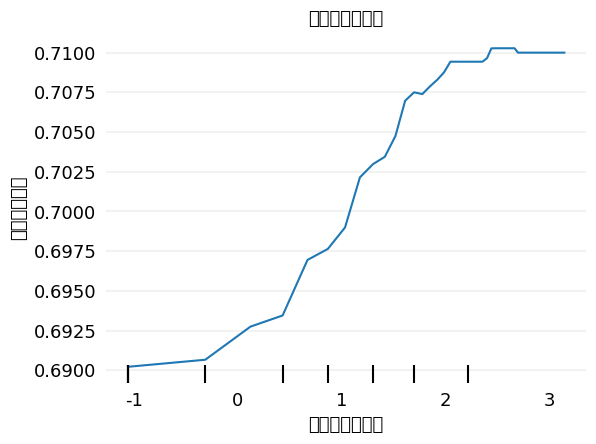

In [59]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
PartialDependenceDisplay.from_estimator(model_gbr_fig,x_test,['Analyst_num'],grid_resolution=100,n_jobs = -1,method = 'brute')
plt.ylabel('股利支付意愿',fontsize = 13)
plt.xlabel('分析师跟踪人数',fontsize = 13)
plt.title('渐进梯度分类树',fontsize = 13)
plt.tick_params(labelsize=13)
plt.subplots_adjust(left=0.15,bottom = 0.15)
ax=plt.gca() 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.grid(linewidth=0.1,color='black',linestyle='--')
ax.tick_params(bottom=False,top=False,left=False,right=False)
plt.savefig(RESULT_DIR / '分析师跟踪人数.png', dpi=200)

TypeError: quantile() got an unexpected keyword argument 'interpolation'

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


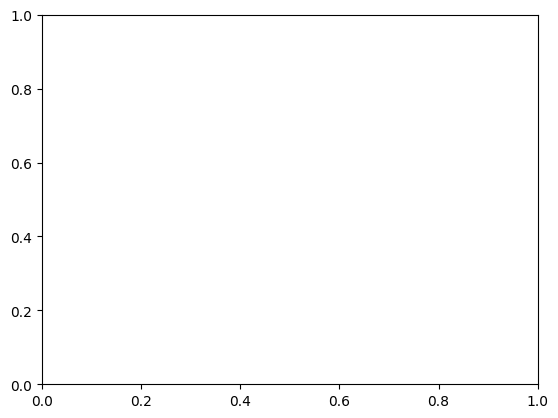

In [60]:
ale_plot(model_gbr_fig, train_set=x_test, monte_carlo=True, rugplot_lim=None, features=['Analyst_num'],)
plt.ylabel('股利支付意愿',fontsize = 13)
plt.xlabel('分析师跟踪人数',fontsize = 13)
plt.title('ALE图-渐进梯度分类树',fontsize = 13)
plt.tick_params(labelsize=13)
plt.subplots_adjust(left=0.15,bottom = 0.15)
ax=plt.gca() 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.grid(linewidth=0.1,color='black',linestyle='--')
ax.tick_params(bottom=False,top=False,left=False,right=False)
plt.savefig(RESULT_DIR / '分析师跟踪人数-ale.png', dpi=200)

TypeError: quantile() got an unexpected keyword argument 'interpolation'

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


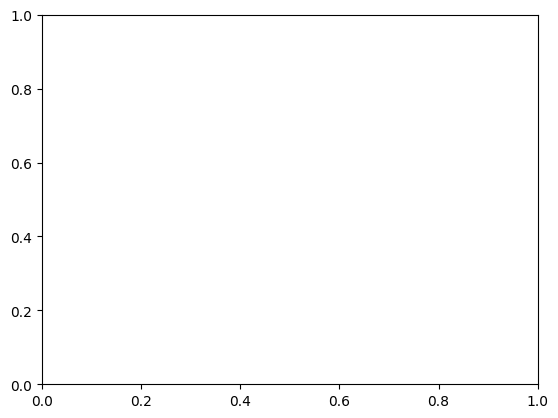

In [61]:
ale_plot(model_gbr_fig, train_set=x_test, monte_carlo=True, rugplot_lim=None, features=['Cashflow'],)
plt.ylabel('股利支付意愿',fontsize = 13)
plt.xlabel('每股经营活动现金流量',fontsize = 13)
plt.title('ALE图-渐进梯度分类树',fontsize = 13)
plt.tick_params(labelsize=13)
plt.subplots_adjust(left=0.15,bottom = 0.15)
ax=plt.gca() 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.grid(linewidth=0.1,color='black',linestyle='--')
ax.tick_params(bottom=False,top=False,left=False,right=False)
plt.savefig(RESULT_DIR / '每股经营活动现金流量-ale.png', dpi=200)

TypeError: quantile() got an unexpected keyword argument 'interpolation'

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


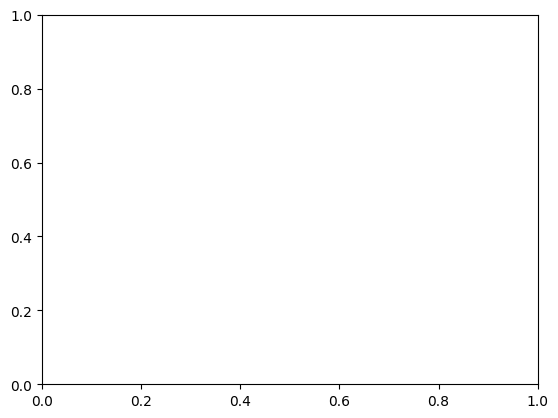

In [62]:
ale_plot(model_forest_fig, train_set=x_test, monte_carlo=True, rugplot_lim=None, features=['Analyst_num'],)
plt.ylabel('股利支付意愿',fontsize = 13)
plt.xlabel('分析师跟踪人数',fontsize = 13)
plt.title('ALE图-随机森林',fontsize = 13)
plt.tick_params(labelsize=13)
plt.subplots_adjust(left=0.15,bottom = 0.15)
ax=plt.gca() 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.grid(linewidth=0.1,color='black',linestyle='--')
ax.tick_params(bottom=False,top=False,left=False,right=False)
plt.savefig(RESULT_DIR / '分析师跟踪人数-ale-forest.png', dpi=200)

TypeError: quantile() got an unexpected keyword argument 'interpolation'

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


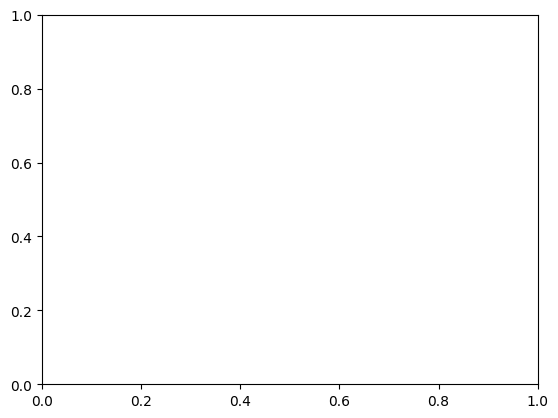

In [63]:
ale_plot(model_forest_fig, train_set=x_test, monte_carlo=True, rugplot_lim=None, features=['Cashflow'],)
plt.ylabel('股利支付意愿',fontsize = 13)
plt.xlabel('每股经营活动现金流量',fontsize = 13)
plt.title('ALE图-随机森林',fontsize = 13)
plt.tick_params(labelsize=13)
plt.subplots_adjust(left=0.15,bottom = 0.15)
ax=plt.gca() 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.grid(linewidth=0.1,color='black',linestyle='--')
ax.tick_params(bottom=False,top=False,left=False,right=False)
plt.savefig(RESULT_DIR / '每股经营活动现金流量-ale-forest.png', dpi=200)

In [64]:
###### 数据导入
data = pd.read_csv(DATA_DIR / 'datauncater.csv', header=0)
data = pd.DataFrame(data)
print(data.head(3))
print(data.shape)

   Stkcd  year  Dividend_ratio1  Dividend_ratio2  Dividend_ratio3  Dividend  \
0      2  2006         0.304220         1.351294         0.971503         1   
1      2  2013         0.298716         0.942424         5.105866         1   
2      2  2015         0.439151         1.301688         2.947196         1   

   Managefee_ratio  Manageshare  Indep_ratio   Bgender  ...  ind32  ind33  \
0         0.047734       0.0292     0.363636  0.181818  ...      0      0   
1         0.022174       0.2884     0.363636  0.181818  ...      0      0   
2         0.024266       0.1912     0.363636  0.090909  ...      0      0   

   ind34  ind35  ind37  ind38  ind39  ind40  ind41  ind42  
0      0      0      0      1      0      0      0      0  
1      0      0      0      1      0      0      0      0  
2      0      0      0      1      0      0      0      0  

[3 rows x 77 columns]
(29058, 77)


In [65]:
###### 数据预处理
x = data.iloc[:, 6:]
# x = data.iloc[:, 6:38]
y = data.iloc[:, 2] #股利分配率
# y = data.iloc[:, 1] #是否发放股利

x_train1 = x.loc[data['year']==2006]
y_train1 = y.loc[data['year']==2006]
sc = StandardScaler()
sc.fit(x_train1)
x_train1 = sc.transform(x_train1)
x_train1 = pd.DataFrame(x_train1,columns= x.columns)

for i in range(2,18):
    exec ("x_train%s=1"%i)
    exec ("y_train%s=1"%i)

x_train = [x_train1,x_train2,x_train3,x_train4,x_train5,x_train6,x_train7,x_train8,x_train9,x_train10,x_train11,x_train12,x_train13,
           x_train14,x_train15,x_train16,x_train17]
y_train = [y_train1,y_train2,y_train3,y_train4,y_train5,y_train6,y_train7,y_train8,y_train9,y_train10,y_train11,y_train12,y_train13,
          y_train14,y_train15,y_train16,y_train17]

for i in range(1,18):
    j = i + 2005
    k = i - 1
    x_train[k] = x.loc[data['year']== j]
    y_train[k] = y.loc[data['year']== j]
    x_train[k] = sc.transform(x_train[k])
    x_train[k] = pd.DataFrame(x_train[k],columns= x.columns)

In [66]:
x_test = sc.transform(x)
x_test = pd.DataFrame(x_test,columns= x.columns)

names = list(x_train1.columns)

In [67]:
model_gbr_fig = GradientBoostingRegressor(n_estimators =3000 , max_depth = 4,subsample = 0.7,learning_rate = 0.001,random_state=0)
model_gbr_fig.fit(x_test,y)

,"loss loss: {'squared_error', 'absolute_error', 'huber', 'quantile'}, default='squared_error'Loss function to be optimized. 'squared_error' refers to the squarederror for regression. 'absolute_error' refers to the absolute error ofregression and is a robust loss function. 'huber' is acombination of the two. 'quantile' allows quantile regression (use`alpha` to specify the quantile).See:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_quantile.py`for an example that demonstrates quantile regression for creatingprediction intervals with `loss='quantile'`.",'squared_error'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.",0.001
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",3000
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",0.7
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are""friedman_mse"" for the mean squared error with improvement score byFriedman, ""squared_error"" for mean squared error. The default value of""friedman_mse"" is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",4
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in thele

In [68]:
model_forest_fig = RandomForestRegressor(n_estimators=5000, max_features=12,random_state=0, n_jobs=-1)
model_forest_fig.fit(x_test,y)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",5000
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",12
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

TypeError: quantile() got an unexpected keyword argument 'interpolation'

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


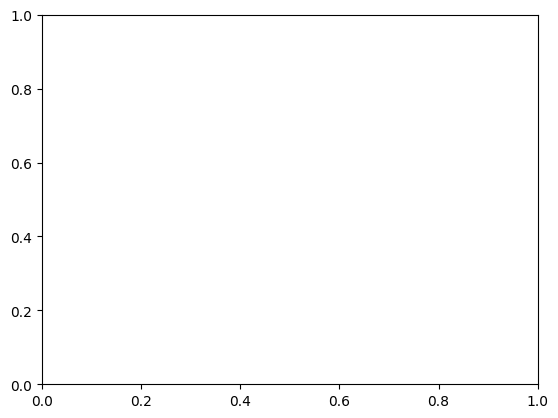

In [69]:
ale_plot(model_gbr_fig, train_set=x_test, monte_carlo=True, rugplot_lim=None, features=['Freecash2'],)
plt.ylabel('股利支付率',fontsize = 13)
plt.xlabel('每股经营活动现金流量',fontsize = 13)
plt.title('ALE图-渐进梯度回归树',fontsize = 13)
plt.tick_params(labelsize=13)
plt.subplots_adjust(left=0.15,bottom = 0.15)
ax=plt.gca() 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.grid(linewidth=0.1,color='black',linestyle='--')
ax.tick_params(bottom=False,top=False,left=False,right=False)
plt.savefig(RESULT_DIR / 'uncater-cashflow-gbr.png', dpi=200)

TypeError: quantile() got an unexpected keyword argument 'interpolation'

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


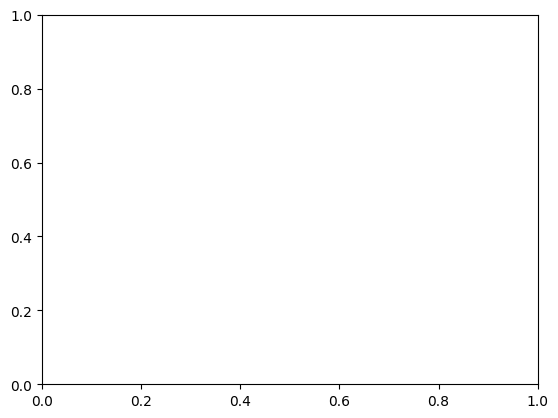

In [70]:
ale_plot(model_gbr_fig, train_set=x_test, monte_carlo=True, rugplot_lim=None, features=['Freecash2'],)
plt.ylabel('股利支付率',fontsize = 13)
plt.xlabel('每股经营活动现金流量',fontsize = 13)
plt.title('ALE图-渐进梯度回归树',fontsize = 13)
plt.tick_params(labelsize=13)
plt.subplots_adjust(left=0.15,bottom = 0.15)
ax=plt.gca() 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.grid(linewidth=0.1,color='black',linestyle='--')
ax.tick_params(bottom=False,top=False,left=False,right=False)
plt.savefig(RESULT_DIR / 'uncater-cashflow-gbr.png', dpi=200)

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


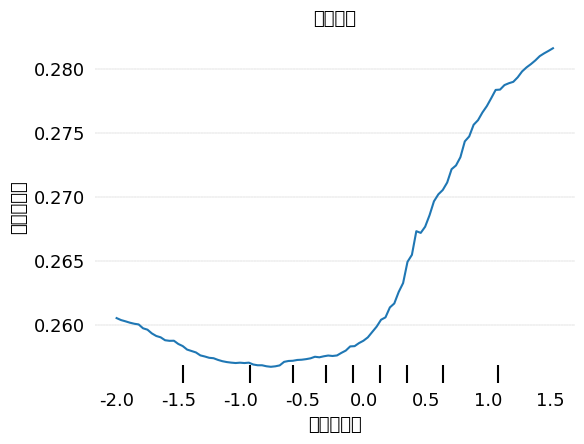

In [71]:
plt.rcParams['font.sans-serif']=['Times New Roman'] #用来正常显示中文标签
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
PartialDependenceDisplay.from_estimator(model_forest_fig,x_test,['Freecash2'],grid_resolution=100,n_jobs = -1,method = 'brute')
plt.ylabel('股利支付率',fontsize = 13)
plt.xlabel('自由现金流',fontsize = 13)
plt.title('随机森林',fontsize = 13) 
plt.tick_params(labelsize=13)
plt.subplots_adjust(left=0.15,bottom = 0.15)
ax=plt.gca() 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.grid(linewidth=0.1,color='black',linestyle='--')
ax.tick_params(bottom=False,top=False,left=False,right=False)
plt.savefig(RESULT_DIR / 'uncatwe-freecash-forest-part.png', dpi=200)

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


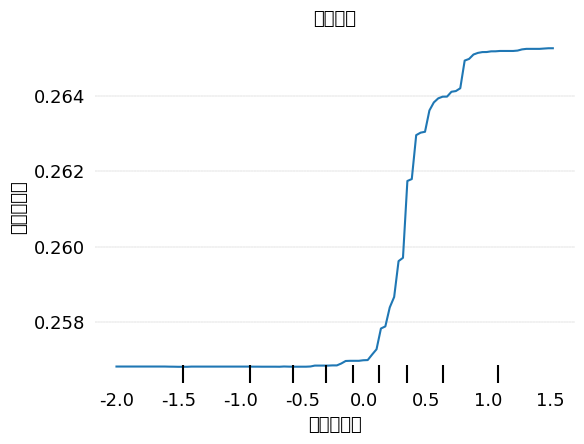

In [72]:
plt.rcParams['font.sans-serif']=['Times New Roman'] #用来正常显示中文标签
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
PartialDependenceDisplay.from_estimator(model_gbr_fig,x_test,['Freecash2'],grid_resolution=100,n_jobs = -1,method = 'brute')
plt.ylabel('股利支付率',fontsize = 13)
plt.xlabel('自由现金流',fontsize = 13)
plt.title('随机森林',fontsize = 13) 
plt.tick_params(labelsize=13)
plt.subplots_adjust(left=0.15,bottom = 0.15)
ax=plt.gca() 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.grid(linewidth=0.1,color='black',linestyle='--')
ax.tick_params(bottom=False,top=False,left=False,right=False)
plt.savefig(RESULT_DIR / 'uncater-freecash-gbr-part.png', dpi=200)

TypeError: quantile() got an unexpected keyword argument 'interpolation'

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


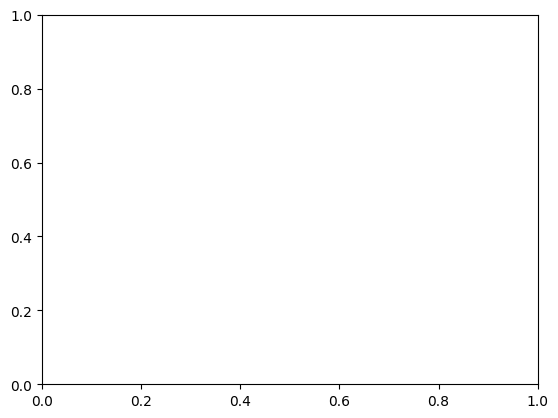

In [73]:
ale_plot(model_forest_fig, train_set=x_test, monte_carlo=True, rugplot_lim=None, features=['Lev'],)
plt.ylabel('股利支付率',fontsize = 13)
plt.xlabel('杠杆率',fontsize = 13)
plt.title('ALE图-随机森林',fontsize = 13)
plt.tick_params(labelsize=13)
plt.subplots_adjust(left=0.15,bottom = 0.15)
ax=plt.gca() 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.grid(linewidth=0.1,color='black',linestyle='--')
ax.tick_params(bottom=False,top=False,left=False,right=False)
plt.savefig(RESULT_DIR / 'uncater-lev-forest.png', dpi=200)

TypeError: quantile() got an unexpected keyword argument 'interpolation'

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


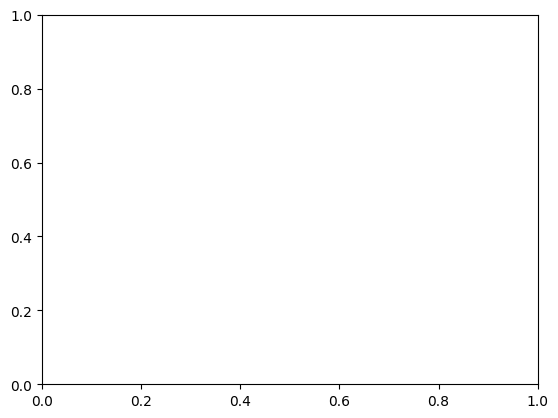

In [74]:
ale_plot(model_gbr_fig, train_set=x_test, monte_carlo=True, rugplot_lim=None, features=['Lev'],)
plt.ylabel('股利支付率',fontsize = 13)
plt.xlabel('杠杆率',fontsize = 13)
plt.title('ALE图-渐进梯度回归树',fontsize = 13)
plt.tick_params(labelsize=13)
plt.subplots_adjust(left=0.15,bottom = 0.15)
ax=plt.gca() 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.grid(linewidth=0.1,color='black',linestyle='--')
ax.tick_params(bottom=False,top=False,left=False,right=False)
plt.savefig(RESULT_DIR / 'uncater-lev-gbr.png', dpi=200)

In [75]:
plt.rcParams['font.sans-serif']=['Times New Roman'] #用来正常显示中文标签
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
PartialDependenceDisplay.from_estimator(model_forest_fig,x_train,['Lev'],grid_resolution=100,n_jobs = -1,method = 'brute')
plt.ylabel('股利支付率',fontsize = 13)
plt.xlabel('杠杆率',fontsize = 13)
plt.title('随机森林',fontsize = 13) 
plt.tick_params(labelsize=13)
plt.subplots_adjust(left=0.15,bottom = 0.15)
ax=plt.gca() 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.grid(linewidth=0.1,color='black',linestyle='--')
ax.tick_params(bottom=False,top=False,left=False,right=False)
plt.savefig(RESULT_DIR / 'uncatwe-lev-forest-part.png', dpi=200)

ValueError: Expected 2D array, got 1D array instead:
array=[     Managefee_ratio  Manageshare  Indep_ratio   Bgender    Bshare      Bage  \
 0          -0.508733    -0.221196     0.323661  0.848724 -0.193461  0.729673
 1          -0.228618     0.008291    -0.431277  2.438046 -0.048650  0.070860
 2           3.694717    -0.225495     0.323661  0.848724 -0.197488  2.097340
 3           1.200944    -0.224759    -1.261710 -0.009510 -0.197488 -0.068633
 4          -0.160207    -0.223508    -0.431277 -1.058463 -0.197488  0.070860
 ..               ...          ...          ...       ...       ...       ...
 749         1.010161    -0.225495    -0.431277  0.107040 -0.197488  0.207644
 750        -0.727740    -0.225495    -0.431277  0.107040 -0.197488  0.602748
 751         0.310137     0.040766    -1.261710  1.039443 -0.197488 -1.131054
 752        -0.612217    -0.225495    -0.431277 -1.058463 -0.197488 -0.210944
 753         0.119696    -0.225495     1.941387 -1.058463 -0.197488 -0.810810

       Btenure   Bsalary    Equity    Da_abs  ...     ind32     ind33  \
 0    1.044725  1.058622  4.750000  0.302017  ... -0.236691 -0.127171
 1    0.781929  0.977963  4.750000  1.334418  ... -0.236691 -0.127171
 2    0.249627  0.795942 -0.210526 -0.874119  ... -0.236691 -0.127171
 3   -1.383009 -1.336747 -0.210526 -0.817195  ... -0.236691 -0.127171
 4   -1.779271 -1.336747  4.750000  0.402773  ... -0.236691 -0.127171
 ..        ...       ...       ...       ...  ...       ...       ...
 749 -0.146636  0.637231 -0.210526  0.245848  ... -0.236691 -0.127171
 750  0.512423  0.677718 -0.210526 -0.256844  ... -0.236691 -0.127171
 751  0.669682 -1.336747 -0.210526  0.696243  ... -0.236691 -0.127171
 752  0.639866  0.805104 -0.210526 -0.498206  ... -0.236691 -0.127171
 753  0.443126 -1.336747 -0.210526  1.305665  ... -0.236691 -0.127171

         ind34     ind35     ind37     ind38  ind39  ind40  ind41  ind42
 0   -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 1   -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 2   -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 3   -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 4   -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 ..        ...       ...       ...       ...    ...    ...    ...    ...
 749 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 750 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 751 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 752 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 753 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0

 [754 rows x 71 columns]
      Managefee_ratio  Manageshare  Indep_ratio   Bgender    Bshare      Bage  \
 0          -0.177179     0.008291    -0.431277  2.438046 -0.048650  0.207644
 1           2.230234    -0.225362    -0.431277  0.107040 -0.197488  0.070860
 2          -0.226107    -0.223434    -0.431277 -1.058463 -0.194243  1.670290
 3           1.419797    -0.225495    -0.431277  2.438046 -0.197488 -2.189667
 4          -0.451349    -0.225097    -0.431277  1.272543 -0.197488 -0.810810
 ..               ...          ...          ...       ...       ...       ...
 740         0.330200    -0.225495    -0.431277  0.107040 -0.197488  0.341823
 741        -0.880363    -0.225495    -0.431277  0.107040 -0.197488  0.729673
 742        -0.813238    -0.225495     0.606763  0.252728 -0.197488  0.070860
 743        -0.050270    -0.225495     2.762695 -1.058463 -0.197488  0.207644
 744        -0.395472    -0.225495    -0.431277 -1.058463 -0.197488  0.473493

       Btenure   Bsalary    Equity    Da_abs  ...     ind32     ind33  \
 0    1.065945  0.820760 -0.210526  1.480859  ... -0.236691 -0.127171
 1   -0.207043 -1.336747 -0.210526 -0.002881  ... -0.236691 -0.127171
 2   -2.858385  1.034985 -0.210526  0.764194  ... -0.236691 -0.127171
 3   -0.485438  0.951696 -0.210526 -0.080830  ... -0.236691 -0.127171
 4    1.086790  0.821597 -0.210526 -1.013465  ... -0.236691 -0.127171
 ..        ...       ...       ...       ...  ...       ...       ...
 740  0.406887  0.717187 -0.210526 -0.821506  ... -0.236691 -0.127171
 741  0.859607  0.753695 -0.210526  0.475222  ... -0.236691 -0.127171
 742 -0.850707 -1.336747 -0.210526 -0.620219  ... -0.236691 -0.127171
 743 -0.748234 -1.336747 -0.210526 -0.791083  ...  4.224926 -0.127171
 744  0.669682 -1.336747 -0.210526  0.209220  ... -0.236691 -0.127171

         ind34     ind35     ind37     ind38  ind39  ind40  ind41  ind42
 0   -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 1   -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 2   -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 3   -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 4   -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 ..        ...       ...       ...       ...    ...    ...    ...    ...
 740 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 741 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 742 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 743 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 744 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0

 [745 rows x 71 columns]
      Managefee_ratio  Manageshare  Indep_ratio   Bgender    Bshare      Bage  \
 0          -0.310532     0.151189    -0.431277  2.438046  0.064534  0.341823
 1          -0.122452    -0.081905    -0.431277 -1.058463 -0.103764  1.779504
 2           1.078302    -0.225377     0.323661 -1.058463 -0.197488 -0.655987
 3           1.695326    -0.225495    -0.431277  2.438046 -0.197488 -2.001812
 4          -0.072690    -0.225495    -0.431277  1.272543 -0.197488 -0.655987
 ..               ...          ...          ...       ...       ...       ...
 811        -0.573366     1.407649    -0.431277  1.272543 -0.197488  0.729673
 812        -0.611413    -0.225495    -0.431277 -1.058463 -0.197488  1.332105
 813         0.150252    -0.225495     1.941387  0.440041 -0.197488 -0.655987
 814        -0.392583    -0.225495    -0.431277 -1.058463 -0.197488  0.341823
 815        -0.681353    -0.225465    -0.431277 -0.359161 -0.197488  1.559356

       Btenure   Bsalary    Equity    Da_abs  ...     ind32     ind33  \
 0    1.294602  0.915314 -0.210526 -0.445912  ... -0.236691 -0.127171
 1   -0.566691  0.998436  4.750000  0.170129  ... -0.236691 -0.127171
 2    1.311795  0.913741 -0.210526 -0.490159  ... -0.236691 -0.127171
 3    0.206797  0.841671 -0.210526 -1.022620  ... -0.236691 -0.127171
 4    1.311795  0.878496 -0.210526 -0.241873  ... -0.236691 -0.127171
 ..        ...       ...       ...       ...  ...       ...       ...
 811  0.206797  1.133870 -0.210526 -0.200634  ... -0.236691 -0.127171
 812  0.443126  0.792878 -0.210526 -0.062654  ... -0.236691 -0.127171
 813 -0.089175  0.956535 -0.210526 -0.623217  ... -0.236691 -0.127171
 814 -0.089175 -1.336747 -0.210526  0.319284  ... -0.236691 -0.127171
 815  1.044725 -1.336747 -0.210526 -0.711067  ...  4.224926 -0.127171

         ind34     ind35     ind37     ind38  ind39  ind40  ind41  ind42
 0   -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 1   -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 2   -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 3   -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 4   -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 ..        ...       ...       ...       ...    ...    ...    ...    ...
 811 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 812 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 813 -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 814 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 815 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0

 [816 rows x 71 columns]
      Managefee_ratio  Manageshare  Indep_ratio   Bgender    Bshare      Bage  \
 0          -0.099869    -0.110714    -0.431277 -1.058463 -0.125640  1.887051
 1          -0.061856    -0.225407     2.336832 -1.058463 -0.197488 -0.504494
 2           1.589361    -0.225495    -0.431277  3.603550 -0.197488 -0.210944
 3           0.378208    -0.225495    -0.431277  0.107040 -0.197488 -0.504494
 4           0.015632    -0.223404    -0.431277  0.107040 -0.197488 -0.356190
 ..               ...          ...          ...       ...       ...       ...
 897        -0.607109    -0.225495     2.336832 -1.058463 -0.197488  0.473493
 898         0.586545    -0.225318     0.057212 -1.058463 -0.197488  0.341823
 899        -0.467023    -0.225495     5.500385 -1.058463 -0.197488  0.207644
 900        -0.397921    -0.225436    -0.431277  0.107040 -0.197488  0.729673
 901        -0.714710    -0.225465    -0.431277 -0.359161 -0.197488  1.670290

       Btenure   Bsalary    Equity    Da_abs  ...     ind32     ind33  \
 0    0.162350  1.037834 -0.210526 -0.088908  ... -0.236691 -0.127171
 1    1.500630  0.933964 -0.210526 -0.206168  ... -0.236691 -0.127171
 2   -2.858385 -1.336747 -0.210526  0.454954  ... -0.236691 -0.127171
 3    1.500630  0.845616 -0.210526 -1.042199  ... -0.236691 -0.127171
 4    1.543460 -1.336747 -0.210526 -0.554538  ... -0.236691 -0.127171
 ..        ...       ...       ...       ...  ...       ...       ...
 897 -1.225749  0.922243 -0.210526  0.819700  ... -0.236691 -0.127171
 898  1.259444 -1.336747 -0.210526  1.355265  ... -0.236691 -0.127171
 899 -0.653968 -1.336747 -0.210526 -0.475212  ... -0.236691 -0.127171
 900  0.545600 -1.336747 -0.210526 -0.188975  ... -0.236691 -0.127171
 901  1.277154 -1.336747 -0.210526 -0.979004  ...  4.224926 -0.127171

         ind34     ind35     ind37     ind38  ind39  ind40  ind41  ind42
 0   -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 1   -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 2   -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 3   -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 4   -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 ..        ...       ...       ...       ...    ...    ...    ...    ...
 897 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 898 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 899 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 900 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 901 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0

 [902 rows x 71 columns]
      Managefee_ratio  Manageshare  Indep_ratio   Bgender    Bshare      Bage  \
 0           0.076524    -0.225362     0.606763  0.252728 -0.197488  0.473493
 1          -0.198984    -0.129675    -0.431277 -1.058463 -0.136761  1.992980
 2           0.078173    -0.225421     2.336832 -1.058463 -0.197488 -0.356190
 3           1.067457    -0.225495    -0.431277  3.603550 -0.197488 -0.068633
 4          -0.570532    -0.225495     1.941387 -1.058463 -0.197488 -0.210944
 ..               ...          ...          ...       ...       ...       ...
 931        -0.503866    -0.225171     2.336832  0.107040 -0.196958  0.473493
 932         1.072539    -0.225289     0.057212 -1.058463 -0.197488  0.473493
 933        -0.522240    -0.225495     5.104941 -1.058463 -0.197488  0.341823
 934        -0.443690    -0.225495    -0.431277  0.107040 -0.197488  0.854352
 935        -0.731040    -0.225465    -0.431277  0.340141 -0.197488  0.729673

       Btenure   Bsalary    Equity    Da_abs  ...     ind32     ind33  \
 0    1.044725  0.962042 -0.210526 -0.051478  ... -0.236691 -0.127171
 1    0.609274  1.077287 -0.210526  0.325375  ... -0.236691 -0.127171
 2    1.663329 -1.336747 -0.210526 -0.101033  ... -0.236691 -0.127171
 3   -0.653968  0.860082 -0.210526 -0.690918  ... -0.236691 -0.127171
 4    0.727142 -1.336747 -0.210526 -0.203944  ... -0.236691 -0.127171
 ..        ...       ...       ...       ...  ...       ...       ...
 931  0.206797 -1.336747 -0.210526  1.246744  ... -0.236691 -0.127171
 932  1.456183 -1.336747 -0.210526  0.954783  ... -0.236691 -0.127171
 933  0.116160 -1.336747 -0.210526 -0.903366  ... -0.236691 -0.127171
 934  0.884402 -1.336747 -0.210526 -0.405414  ... -0.236691 -0.127171
 935 -1.779271 -1.336747 -0.210526 -1.021090  ...  4.224926 -0.127171

         ind34     ind35     ind37     ind38  ind39  ind40  ind41  ind42
 0   -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 1   -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 2   -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 3   -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 4   -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 ..        ...       ...       ...       ...    ...    ...    ...    ...
 931 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 932 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 933 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 934 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 935 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0

 [936 rows x 71 columns]
       Managefee_ratio  Manageshare  Indep_ratio   Bgender    Bshare      Bage  \
 0           -0.755480     0.039617    -0.431277  0.107040 -0.009403  0.729673
 1           -0.280148    -0.225495    -0.431277  0.107040 -0.197488  0.602748
 2           -0.170965    -0.128718    -0.431277 -1.058463 -0.136735  2.097340
 3            1.001646    -0.225495    -0.431277 -1.058463 -0.197488  0.854352
 4            0.795789    -0.225495    -0.431277  1.272543 -0.197488  0.070860
 ...               ...          ...          ...       ...       ...       ...
 1121        -0.602041    -0.114822     0.323661 -1.058463  1.498374  0.729673
 1122        -0.463962    -0.225495    -0.431277  0.107040 -0.197488 -0.068633
 1123        -0.581328    -0.225495     0.323661 -1.058463 -0.197488 -0.356190
 1124        -0.358288    -0.225495     0.846311 -0.251576 -0.197488  1.446647
 1125        -0.733485    -0.225465    -0.431277  0.340141 -0.197488  0.854352

        Btenure   Bsalary    Equity    Da_abs  ...     ind32     ind33  \
 0     1.794986  0.995720 -0.210526 -0.395728  ... -0.236691 -0.127171
 1     1.277154  0.967354 -0.210526 -0.692525  ... -0.236691 -0.127171
 2     0.932478  1.065125 -0.210526 -0.499598  ... -0.236691 -0.127171
 3    -0.962953  0.965996 -0.210526 -1.001025  ... -0.236691 -0.127171
 4     0.116160  0.925108 -0.210526  0.091750  ... -0.236691 -0.127171
 ...        ...       ...       ...       ...  ...       ...       ...
 1121  1.241464  1.206186 -0.210526  2.260377  ... -0.236691 -0.127171
 1122 -2.042067  1.012392 -0.210526 -0.692918  ... -0.236691 -0.127171
 1123 -1.564552 -1.336747 -0.210526  1.208171  ... -0.236691 -0.127171
 1124  0.834280 -1.336747 -0.210526 -0.517749  ... -0.236691 -0.127171
 1125 -0.338034 -1.336747 -0.210526 -0.809914  ...  4.224926 -0.127171

          ind34     ind35     ind37     ind38  ind39  ind40  ind41  ind42
 0    -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 1    -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 2    -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 3    -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 4    -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 ...        ...       ...       ...       ...    ...    ...    ...    ...
 1121 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 1122 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 1123 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 1124 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 1125 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0

 [1126 rows x 71 columns]
       Managefee_ratio  Manageshare  Indep_ratio   Bgender    Bshare      Bage  \
 0            1.128569    -0.225097    -0.431277  0.107040 -0.196720  0.070860
 1           -0.364903    -0.225495    -0.431277  0.107040 -0.197488  0.854352
 2           -0.154079    -0.139332    -0.431277 -1.058463 -0.136720  2.200176
 3            0.932791    -0.225495    -0.431277 -1.058463 -0.197488  0.976862
 4            1.507214    -0.225495    -0.431277 -1.058463 -0.197488  0.207644
 ...               ...          ...          ...       ...       ...       ...
 1469        -0.786909     6.651776    -0.431277  0.107040  5.833113 -1.131054
 1470        -0.503002    -0.225495     0.323661 -1.058463 -0.197488 -0.210944
 1471        -0.224133    -0.225495     0.846311 -0.251576 -0.197488  1.446647
 1472        -0.696894    -0.225465    -0.431277  0.340141 -0.197488  0.976862
 1473        -0.296086    -0.225495     0.323661 -1.058463 -0.197488  1.215670

        Btenure   Bsalary    Equity    Da_abs  ...     ind32     ind33  \
 0    -0.409431  0.812920 -0.210526  0.089086  ... -0.236691 -0.127171
 1     1.471186  0.970439 -0.210526  1.725482  ... -0.236691 -0.127171
 2     1.185814  0.994250 -0.210526 -0.843932  ... -0.236691 -0.127171
 3    -0.034389  0.968127 -0.210526 -0.770806  ... -0.236691 -0.127171
 4     0.577867  0.940447 -0.210526 -0.645167  ... -0.236691 -0.127171
 ...        ...       ...       ...       ...  ...       ...       ...
 1469  0.698763  0.838675 -0.210526 -0.434463  ... -0.236691 -0.127171
 1470 -0.270718 -1.336747 -0.210526  0.582381  ... -0.236691 -0.127171
 1471  1.107272 -1.336747 -0.210526 -0.838961  ... -0.236691 -0.127171
 1472  0.290954 -1.336747 -0.210526 -0.642606  ...  4.224926 -0.127171
 1473  0.808395 -1.336747 -0.210526 -0.375517  ... -0.236691 -0.127171

          ind34     ind35     ind37     ind38  ind39  ind40  ind41  ind42
 0    -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 1    -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 2    -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 3    -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 4    -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 ...        ...       ...       ...       ...    ...    ...    ...    ...
 1469  3.400980 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 1470 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 1471 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 1472 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 1473 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0

 [1474 rows x 71 columns]
       Managefee_ratio  Manageshare  Indep_ratio   Bgender    Bshare      Bage  \
 0           -0.837167    -0.183039     0.323661  0.848724 -0.178109  1.559356
 1            1.840022    -0.225097    -0.431277  1.272543 -0.196720  0.207644
 2            4.723237    -0.225495    -0.431277  2.438046 -0.197488  1.670290
 3           -0.921114    -0.064137    -0.431277  0.107040 -0.062277  0.976862
 4           -0.251845    -0.225495    -0.431277  0.107040 -0.197488  0.976862
 ...               ...          ...          ...       ...       ...       ...
 1564        -0.825389     6.909071    -0.431277  0.107040  6.719568 -0.969113
 1565        -0.533028    -0.225495     0.323661 -0.104870 -0.197488 -0.068633
 1566        -0.094791    -0.225495     0.846311 -0.251576 -0.197488  1.559356
 1567        -0.508577    -0.225465    -0.431277  0.340141 -0.197488  1.097278
 1568        -0.315556    -0.225495     0.323661 -1.058463 -0.197488  1.215670

        Btenure   Bsalary    Equity    Da_abs  ...     ind32     ind33  \
 0     2.136616  1.233195 -0.210526  0.203130  ... -0.236691 -0.127171
 1     0.249627  0.826538 -0.210526 -0.644676  ... -0.236691 -0.127171
 2     1.913393  0.854020 -0.210526  0.105999  ... -0.236691 -0.127171
 3     2.039522  1.017226 -0.210526  0.910036  ... -0.236691 -0.127171
 4     1.637726  0.989833 -0.210526  1.272177  ... -0.236691 -0.127171
 ...        ...       ...       ...       ...  ...       ...       ...
 1564  1.001101  0.838675 -0.210526 -0.987405  ... -0.236691 -0.127171
 1565  0.330880 -1.336747 -0.210526 -0.086836  ... -0.236691 -0.127171
 1566  1.328741 -1.336747 -0.210526 -0.929048  ... -0.236691 -0.127171
 1567  0.512423 -1.336747 -0.210526 -0.934398  ...  4.224926 -0.127171
 1568  1.086790 -1.336747 -0.210526 -0.748537  ... -0.236691 -0.127171

          ind34     ind35     ind37     ind38  ind39  ind40  ind41  ind42
 0    -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 1    -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 2    -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 3    -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 4    -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 ...        ...       ...       ...       ...    ...    ...    ...    ...
 1564  3.400980 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 1565 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 1566 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 1567 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 1568 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0

 [1569 rows x 71 columns]
       Managefee_ratio  Manageshare  Indep_ratio   Bgender    Bshare      Bage  \
 0            1.204395    -0.225097    -0.431277  1.272543 -0.196720  0.341823
 1            6.117784    -0.225495    -0.431277  2.438046 -0.197488  1.779504
 2           -0.769434    -0.101793    -0.431277  0.107040 -0.096080  1.097278
 3            2.325417    -0.225495     1.229588  3.137348 -0.197488  0.070860
 4           -0.069399    -0.225495    -0.431277  0.107040 -0.197488  1.097278
 ...               ...          ...          ...       ...       ...       ...
 1603        -0.537388    -0.087117    -0.431277 -1.058463 -0.197488  0.473493
 1604         0.157008    -0.003721    -0.431277  0.107040 -0.096445 -2.189667
 1605        -0.405089    -0.087087    -0.431277  0.107040 -0.197488  0.207644
 1606        -0.938672     5.498319     1.941387  0.440041  8.249387  0.070860
 1607        -0.357176     0.081160    -0.431277  1.272543  0.288118 -0.356190

        Btenure   Bsalary    Equity    Da_abs  ...     ind32     ind33  \
 0     0.669682  0.830994 -0.210526 -0.111135  ... -0.236691 -0.127171
 1     2.030285  0.854020 -0.210526 -0.099272  ... -0.236691 -0.127171
 2     2.145058  1.032152 -0.210526  1.249807  ... -0.236691 -0.127171
 3    -0.409431  0.984117 -0.210526  0.537923  ... -0.236691 -0.127171
 4     1.783607  0.985915 -0.210526  2.613534  ... -0.236691 -0.127171
 ...        ...       ...       ...       ...  ...       ...       ...
 1603  0.978668 -1.336747 -0.210526 -1.028114  ... -0.236691 -0.127171
 1604 -0.485438  0.847061 -0.210526 -0.829048  ... -0.236691 -0.127171
 1605  1.001101  1.012392 -0.210526  0.260645  ... -0.236691 -0.127171
 1606  1.241464  0.710294 -0.210526 -1.027741  ... -0.236691 -0.127171
 1607  0.955799  0.974450 -0.210526  2.056424  ... -0.236691 -0.127171

          ind34     ind35     ind37     ind38  ind39  ind40  ind41  ind42
 0    -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 1    -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 2    -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 3    -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 4    -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 ...        ...       ...       ...       ...    ...    ...    ...    ...
 1603 -0.294033  5.515131 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 1604 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 1605 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 1606 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 1607 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0

 [1608 rows x 71 columns]
       Managefee_ratio  Manageshare  Indep_ratio   Bgender     Bshare  \
 0           -0.810288    -0.197348     0.323661 -0.104870  -0.178173
 1            0.832865    -0.011553    -0.431277  1.272543   0.206286
 2            7.544906    -0.225495    -0.431277  3.137348  -0.197488
 3           -0.894834    -0.155069     0.606763  0.252728  -0.096080
 4            1.914518     1.658320     1.941387 -1.058463  -0.197488
 ...               ...          ...          ...       ...        ...
 1677        -0.630905     3.930404     1.941387  0.440041   5.803787
 1678        -0.141993     9.401191     2.336832 -1.058463  15.192855
 1679         0.298850    -0.217545     1.229588 -1.058463  -0.187889
 1680        -0.279492    -0.049431    -0.431277  1.272543   0.040888
 1681        -0.028511    -0.218546     0.606763 -1.058463  -0.184306

           Bage   Btenure   Bsalary    Equity    Da_abs  ...     ind32  \
 0     1.887051  2.324195  1.286252 -0.210526  0.298363  ... -0.236691
 1    -2.382670 -2.380869  0.812974 -0.210526 -0.803341  ... -0.236691
 2     1.887051  2.136616  0.854020 -0.210526 -0.141104  ... -0.236691
 3     1.215670  2.210503  0.912430 -0.210526 -0.081675  ... -0.236691
 4     0.854352 -0.962953  0.785937 -0.210526  3.240751  ... -0.236691
 ...        ...       ...       ...       ...       ...  ...       ...
 1677  0.341823  1.440987  0.758227 -0.210526  3.591591  ... -0.236691
 1678  0.602748  1.107272  0.922416 -0.210526  0.633948  ... -0.236691
 1679  1.097278  0.577867 -1.336747 -0.210526  1.072351  ... -0.236691
 1680 -0.068633  1.204658  0.974450 -0.210526  1.309492  ... -0.236691
 1681 -1.640493  0.068084  1.042185 -0.210526 -0.687183  ... -0.236691

          ind33     ind34     ind35     ind37     ind38  ind39  ind40  ind41  \
 0    -0.127171 -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0
 1    -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 2    -0.127171 -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0
 3    -0.127171 -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0
 4    -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 ...        ...       ...       ...       ...       ...    ...    ...    ...
 1677 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 1678 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 1679 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 1680 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 1681 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0

       ind42
 0       0.0
 1       0.0
 2       0.0
 3       0.0
 4       0.0
 ...     ...
 1677    0.0
 1678    0.0
 1679    0.0
 1680    0.0
 1681    0.0

 [1682 rows x 71 columns]
       Managefee_ratio  Manageshare  Indep_ratio   Bgender    Bshare      Bage  \
 0           -0.758719    -0.198761     0.323661 -0.104870 -0.178152  1.992980
 1            0.098616    -0.011965    -0.431277  1.272543  0.206286 -2.382670
 2            1.346464    -0.225495    -0.431277  3.137348 -0.197488  1.992980
 3            1.540528     1.091057     1.941387 -1.058463  1.723648  0.602748
 4            0.310046    -0.191725     0.323661  1.802317 -0.197488  0.341823
 ...               ...          ...          ...       ...       ...       ...
 1860        -0.284584     5.672572    -0.431277  0.107040  5.734221  1.779504
 1861         0.929685     8.165532     1.941387 -1.058463  8.209348 -0.969113
 1862         0.199452    -0.220416     0.606763 -1.058463 -0.184315 -1.466554
 1863         0.430571    -0.225495    -0.431277  0.107040 -0.197488  0.854352
 1864         1.181913     6.297792     0.606763  1.563919  9.977247 -0.969113

        Btenure   Bsalary    Equity    Da_abs  ...     ind32     ind33  \
 0     2.407854  1.285022 -0.210526 -0.352202  ... -0.236691 -0.127171
 1    -0.485438  0.836249 -0.210526  0.206598  ... -0.236691 -0.127171
 2     2.234136  0.878159 -0.210526 -0.643399  ... -0.236691 -0.127171
 3    -0.034389  1.175380  4.750000  2.486937  ... -0.236691 -0.127171
 4     0.669682  0.993169 -0.210526 -0.826297  ... -0.236691  7.863417
 ...        ...       ...       ...       ...  ...       ...       ...
 1860  0.369496  0.687990 -0.210526  0.739830  ... -0.236691 -0.127171
 1861  0.249627  0.895177 -0.210526 -0.446508  ... -0.236691 -0.127171
 1862  0.545600  1.158396 -0.210526 -0.349972  ... -0.236691 -0.127171
 1863  0.162350  1.036334 -0.210526  1.953168  ... -0.236691 -0.127171
 1864  0.955799  0.879613  4.750000 -0.828017  ... -0.236691 -0.127171

          ind34     ind35     ind37     ind38  ind39  ind40  ind41  ind42
 0    -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 1    -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 2    -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    1.0    0.0
 3    -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 4    -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 ...        ...       ...       ...       ...    ...    ...    ...    ...
 1860 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 1861 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 1862 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 1863 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 1864 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0

 [1865 rows x 71 columns]
       Managefee_ratio  Manageshare  Indep_ratio   Bgender     Bshare  \
 0           -0.653087    -0.209449     0.323661 -0.104870  -0.178152
 1            0.257145    -0.011965    -0.431277  1.272543   0.206286
 2            1.427466    -0.225495    -0.431277  3.137348  -0.197488
 3            1.447821     0.985168     1.941387 -1.058463   1.717635
 4            1.009504    -0.191725     0.323661  1.802317  -0.197488
 ...               ...          ...          ...       ...        ...
 1965         0.349068     8.165532     1.941387 -1.058463   8.209348
 1966        -0.082760     2.710717     1.941387  3.437049  -0.197488
 1967         0.281350    -0.225495    -0.431277  1.272543  -0.197488
 1968         0.879636     5.273439     1.941387  0.440041  10.006619
 1969         0.500598    -0.225495     0.606763 -1.058463  -0.197488

           Bage   Btenure   Bsalary    Equity    Da_abs  ...     ind32  \
 0     2.097340  2.447555  1.286710 -0.210526  0.296983  ... -0.236691
 1    -2.581110  0.206797  0.843792 -0.210526 -0.795147  ... -0.236691
 2     2.097340  2.324195  0.912889 -0.210526 -0.938027  ... -0.236691
 3     0.729673  0.478284  1.178045 -0.210526  1.824266  ... -0.236691
 4     0.473493  0.978668  0.946014 -0.210526  3.728811  ... -0.236691
 ...        ...       ...       ...       ...       ...  ...       ...
 1965 -0.810810  0.669682  0.904312 -0.210526 -0.574437  ... -0.236691
 1966  1.215670  1.204658  0.872796 -0.210526  1.265972  ... -0.236691
 1967  0.976862  0.609274  1.090665  4.750000  1.766651  ... -0.236691
 1968 -0.810810  1.204658  0.895820 -0.210526 -0.621142  ... -0.236691
 1969  0.854352 -0.146636  0.771493 -0.210526 -0.533041  ... -0.236691

          ind33     ind34     ind35     ind37     ind38  ind39  ind40  ind41  \
 0    -0.127171 -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0
 1    -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 2    -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    1.0
 3    -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 4     7.863417 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 ...        ...       ...       ...       ...       ...    ...    ...    ...
 1965 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 1966 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 1967 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 1968 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 1969 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0

       ind42
 0       0.0
 1       0.0
 2       0.0
 3       0.0
 4       0.0
 ...     ...
 1965    0.0
 1966    0.0
 1967    0.0
 1968    0.0
 1969    1.0

 [1970 rows x 71 columns]
       Managefee_ratio  Manageshare  Indep_ratio   Bgender     Bshare  \
 0            1.107655    -0.225495     0.161889  2.687797  -0.197488
 1            0.686544     0.851133    -0.431277 -1.058463   1.855157
 2            3.198440    -0.225495     1.229588  2.088395  -0.197488
 3           -0.647932    -0.225495    -0.431277  0.107040  -0.197488
 4            1.000994    -0.225495    -0.431277 -1.058463  -0.197488
 ...               ...          ...          ...       ...        ...
 2271         1.023715     3.517242    -0.431277 -1.058463   3.979092
 2272        -0.660163    -0.222241     1.941387  0.440041  -0.187188
 2273         0.250226    -0.180389    -0.431277  1.272543  -0.197488
 2274        -0.109360     5.291664     1.941387  0.440041  10.043521
 2275         0.414536    -0.225495     5.500385  1.039443  -0.197488

           Bage   Btenure   Bsalary    Equity    Da_abs  ...     ind32  \
 0     2.200176  2.407854  0.912889 -0.210526  0.263828  ... -0.236691
 1     0.854352  0.834280  1.277991 -0.210526 -0.105009  ... -0.236691
 2     0.602748 -2.042067  0.745644 -0.210526  4.565963  ... -0.236691
 3    -0.210944  2.186385  0.968744 -0.210526  2.102513  ... -0.236691
 4    -0.068633  1.241464 -1.336747 -0.210526 -0.961086  ... -0.236691
 ...        ...       ...       ...       ...       ...  ...       ...
 2271  0.070860  0.698763  1.021319 -0.210526  0.713715  ... -0.236691
 2272 -1.131054  1.147198  1.224370 -0.210526 -0.198462  ... -0.236691
 2273  1.097278  0.932478  1.097088 -0.210526  1.699733  ... -0.236691
 2274 -0.655987  1.409993  0.896661  4.750000 -0.257918  ... -0.236691
 2275  0.976862  0.162350  0.706637 -0.210526 -0.336060  ... -0.236691

          ind33     ind34     ind35     ind37     ind38  ind39  ind40  ind41  \
 0    -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    1.0
 1    -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 2     7.863417 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 3    -0.127171 -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0
 4    -0.127171 -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0
 ...        ...       ...       ...       ...       ...    ...    ...    ...
 2271 -0.127171 -0.294033 -0.181319  5.768252 -0.239799    0.0    0.0    0.0
 2272 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 2273 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 2274 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 2275 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0

       ind42
 0       0.0
 1       0.0
 2       0.0
 3       0.0
 4       0.0
 ...     ...
 2271    0.0
 2272    0.0
 2273    0.0
 2274    0.0
 2275    1.0

 [2276 rows x 71 columns]
       Managefee_ratio  Manageshare  Indep_ratio   Bgender     Bshare  \
 0            1.229268    -0.224082    -0.431277  2.438046   0.025961
 1            1.174587    -0.225495     1.644804  2.438046  -0.197488
 2           -0.644932    -0.225495     1.941387  0.440041  -0.197488
 3            0.637501     0.589406    -0.431277 -1.058463   1.346256
 4           -0.458299    -0.225495    -0.431277  0.107040  -0.197488
 ...               ...          ...          ...       ...        ...
 2553        -0.159290     7.314372    -0.431277  3.603550  10.085204
 2554        -0.891273    -0.222241     0.606763  0.252728  -0.187188
 2555        -0.143849    -0.197304    -0.431277  1.272543  -0.197488
 2556         0.090844     5.233015     1.941387  0.440041   9.865888
 2557         0.271490    -0.225495     0.606763 -1.058463  -0.197488

           Bage   Btenure   Bsalary    Equity    Da_abs  ...     ind32  \
 0    -2.189667  0.754854  0.663111 -0.210526  6.394781  ... -0.236691
 1     2.301533  2.485962  0.912889 -0.210526  0.125701  ... -0.236691
 2     0.207644  0.478284  1.080666 -0.210526  0.734221  ... -0.236691
 3     0.976862  1.107272  1.302879  4.750000  0.043820  ... -0.236691
 4    -0.068633 -0.207043  1.033640 -0.210526  2.616858  ... -0.236691
 ...        ...       ...       ...       ...       ...  ...       ...
 2553  0.976862  1.294602  0.835528 -0.210526  1.797960  ... -0.236691
 2554 -0.969113  1.361917  1.301020 -0.210526 -0.860575  ... -0.236691
 2555  1.215670  1.185814  1.084269 -0.210526  0.593855  ... -0.236691
 2556 -0.504494  1.584787  0.911448 -0.210526 -0.760036  ... -0.236691
 2557 -0.210944 -1.779271 -1.336747 -0.210526  0.015422  ... -0.236691

          ind33     ind34     ind35     ind37     ind38  ind39  ind40  ind41  \
 0    -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 1    -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    1.0
 2    -0.127171 -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0
 3    -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 4    -0.127171 -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0
 ...        ...       ...       ...       ...       ...    ...    ...    ...
 2553 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 2554 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 2555 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 2556 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 2557 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0

       ind42
 0       0.0
 1       0.0
 2       0.0
 3       0.0
 4       0.0
 ...     ...
 2553    0.0
 2554    0.0
 2555    0.0
 2556    0.0
 2557    1.0

 [2558 rows x 71 columns]
       Managefee_ratio  Manageshare  Indep_ratio   Bgender    Bshare      Bage  \
 0           -0.324305    -0.225480     0.606763  2.875110 -0.197488  0.729673
 1            0.835456    -0.225495     0.161889  2.687797 -0.197488  2.401452
 2           -0.561542    -0.225495    -0.431277  0.107040 -0.197488  0.341823
 3            1.254527     0.382766    -0.431277 -1.058463  0.960397  1.097278
 4           -0.375024    -0.225495    -0.431277  0.107040 -0.197488  0.070860
 ...               ...          ...          ...       ...       ...       ...
 2560        -0.078107    -0.225495    -0.431277  1.272543 -0.197488  1.097278
 2561        -0.970804    -0.222241     0.606763  0.252728 -0.190673  0.602748
 2562        -0.075096    -0.209817    -0.431277  2.438046 -0.197488  1.332105
 2563         0.450636     5.256466     1.941387  0.440041  9.983692 -0.356190
 2564         0.209702    -0.225495     0.606763 -1.058463 -0.197488 -0.068633

        Btenure   Bsalary    Equity    Da_abs  ...     ind32     ind33  \
 0    -0.089175  0.853198 -0.210526 -0.915235  ... -0.236691 -0.127171
 1     2.559210  0.899261 -0.210526  2.060018  ... -0.236691 -0.127171
 2     0.834280  1.067515 -0.210526  0.652706  ... -0.236691 -0.127171
 3     1.328741  1.233717 -0.210526  0.522485  ... -0.236691 -0.127171
 4     0.369496  1.151282 -0.210526  1.090237  ... -0.236691 -0.127171
 ...        ...       ...       ...       ...  ...       ...       ...
 2560  1.394185  0.837252 -0.210526  0.250362  ... -0.236691 -0.127171
 2561 -1.383009  0.602956 -0.210526 -0.992687  ... -0.236691 -0.127171
 2562  1.394185  1.086977 -0.210526 -0.261373  ... -0.236691 -0.127171
 2563  1.736960  0.919564 -0.210526  0.709413  ... -0.236691 -0.127171
 2564 -0.338034 -1.336747 -0.210526 -0.049064  ... -0.236691 -0.127171

          ind34     ind35     ind37     ind38  ind39  ind40  ind41  ind42
 0    -0.294033 -0.181319  5.768252 -0.239799    0.0    0.0    0.0    0.0
 1    -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    1.0    0.0
 2    -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 3    -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 4    -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 ...        ...       ...       ...       ...    ...    ...    ...    ...
 2560 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 2561 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 2562 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 2563 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 2564 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    1.0

 [2565 rows x 71 columns]
       Managefee_ratio  Manageshare  Indep_ratio   Bgender     Bshare  \
 0           -0.220012    -0.225480    -0.431277  2.438046  -0.197488
 1           -0.527365    -0.225495     0.606763 -1.058463  -0.197488
 2            0.714038     0.383679    -0.431277  2.438046   0.960397
 3           -0.570131    -0.225495     0.323661  1.802317  -0.197488
 4           -0.367756    -0.225495    -0.431277  1.272543  -0.197488
 ...               ...          ...          ...       ...        ...
 2806        -0.132680     3.886461    -0.431277  0.107040   6.285023
 2807        -0.842556     0.632775    -0.431277  1.272543  -0.197488
 2808        -0.529978     5.789914    -0.431277  0.107040   7.923516
 2809        -0.497199     7.452530     1.941387  1.938545  10.913547
 2810        -0.590785     1.441890     0.606763 -1.058463  -0.197488

           Bage   Btenure   Bsalary    Equity    Da_abs  ...     ind32  \
 0     0.854352  0.443126  0.864399 -0.210526  6.320543  ... -0.236691
 1     0.473493  1.107272  0.963793 -0.210526  0.080301  ... -0.236691
 2     1.215670  1.515081  1.137150 -0.210526  1.623122  ... -0.236691
 3    -0.356190  0.369496  1.024405 -0.210526  0.063994  ... -0.236691
 4     0.207644  0.754854  1.140984 -0.210526  1.340348  ... -0.236691
 ...        ...       ...       ...       ...       ...  ...       ...
 2806  1.332105  1.223205  0.999448 -0.210526 -0.219731  ... -0.236691
 2807 -0.210944  1.650598  1.094538  4.750000  0.303571  ... -0.236691
 2808  0.473493  0.955799  0.956275  4.750000  0.993490  ... -0.236691
 2809  1.215670  1.086790  0.842227 -0.210526  0.031346  ... -0.236691
 2810  2.200176  1.107272  1.357946 -0.210526  6.320543  ... -0.236691

          ind33     ind34     ind35     ind37     ind38  ind39  ind40  ind41  \
 0    -0.127171 -0.294033 -0.181319  5.768252 -0.239799    0.0    0.0    0.0
 1    -0.127171 -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0
 2    -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 3     7.863417 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 4    -0.127171 -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0
 ...        ...       ...       ...       ...       ...    ...    ...    ...
 2806 -0.127171 -0.294033 -0.181319  5.768252 -0.239799    0.0    0.0    0.0
 2807 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 2808 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 2809 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 2810 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0

       ind42
 0       0.0
 1       0.0
 2       0.0
 3       0.0
 4       0.0
 ...     ...
 2806    0.0
 2807    0.0
 2808    0.0
 2809    0.0
 2810    0.0

 [2811 rows x 71 columns]
       Managefee_ratio  Manageshare  Indep_ratio   Bgender     Bshare  \
 0           -0.595251    -0.225495     1.941387  0.440041  -0.197488
 1            0.263962    -0.225495     1.229588  1.039443  -0.197488
 2            1.334523     0.383679    -0.431277  1.272543   0.960397
 3            0.470286    -0.225495     1.229588  1.039443  -0.197488
 4            0.021257    -0.225495    -1.261710  2.088395  -0.197488
 ...               ...          ...          ...       ...        ...
 3396         0.120933     6.115000    -1.617610  0.107040   7.588539
 3397         0.322042     0.067161    -1.617610  0.440041  -0.197488
 3398         0.340959     0.335570     1.941387 -1.058463   0.744045
 3399        -0.561651    -0.225495    -0.431277  1.272543  -0.197488
 3400        -0.419724     9.392049    -1.617610  0.440041  10.567838

           Bage   Btenure   Bsalary    Equity    Da_abs  ...     ind32  \
 0     0.602748  1.311795  0.428716 -0.210526 -0.491425  ... -0.236691
 1    -2.785303  0.609274  1.009615 -0.210526  0.236087  ... -0.236691
 2     1.332105  1.675925  1.100616 -0.210526  0.717484  ... -0.236691
 3    -0.210944  0.754854  1.022460 -0.210526  2.204101  ... -0.236691
 4     0.341823  1.044725  1.136299 -0.210526  0.362922  ... -0.236691
 ...        ...       ...       ...       ...       ...  ...       ...
 3396  1.215670  1.394185  0.901756 -0.210526 -0.734708  ... -0.236691
 3397  2.499973  1.394185  0.873336 -0.210526 -0.882973  ... -0.236691
 3398  0.341823  1.637726  0.845434 -0.210526 -0.198299  ... -0.236691
 3399 -0.655987  1.345446  0.851454 -0.210526 -0.823512  ... -0.236691
 3400  0.854352  1.394185  0.902893 -0.210526 -0.568226  ... -0.236691

          ind33     ind34     ind35     ind37     ind38  ind39  ind40  ind41  \
 0    -0.127171 -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0
 1    -0.127171 -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0
 2    -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 3     7.863417 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 4    -0.127171 -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0
 ...        ...       ...       ...       ...       ...    ...    ...    ...
 3396 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 3397 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 3398 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 3399 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 3400 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0

       ind42
 0       0.0
 1       0.0
 2       0.0
 3       0.0
 4       0.0
 ...     ...
 3396    0.0
 3397    0.0
 3398    0.0
 3399    0.0
 3400    0.0

 [3401 rows x 71 columns]                                                      ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [76]:
plt.rcParams['font.sans-serif']=['Times New Roman'] #用来正常显示中文标签
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
PartialDependenceDisplay.from_estimator(model_gbr_fig,x_train,['Lev'],grid_resolution=100,n_jobs = -1,method = 'brute')
plt.ylabel('股利支付率',fontsize = 13)
plt.xlabel('杠杆率',fontsize = 13)
plt.title('随机森林',fontsize = 13) 
plt.tick_params(labelsize=13)
plt.subplots_adjust(left=0.15,bottom = 0.15)
ax=plt.gca() 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.grid(linewidth=0.1,color='black',linestyle='--')
ax.tick_params(bottom=False,top=False,left=False,right=False)
plt.savefig(RESULT_DIR / 'uncater-lev-gbr-part.png', dpi=200)

ValueError: Expected 2D array, got 1D array instead:
array=[     Managefee_ratio  Manageshare  Indep_ratio   Bgender    Bshare      Bage  \
 0          -0.508733    -0.221196     0.323661  0.848724 -0.193461  0.729673
 1          -0.228618     0.008291    -0.431277  2.438046 -0.048650  0.070860
 2           3.694717    -0.225495     0.323661  0.848724 -0.197488  2.097340
 3           1.200944    -0.224759    -1.261710 -0.009510 -0.197488 -0.068633
 4          -0.160207    -0.223508    -0.431277 -1.058463 -0.197488  0.070860
 ..               ...          ...          ...       ...       ...       ...
 749         1.010161    -0.225495    -0.431277  0.107040 -0.197488  0.207644
 750        -0.727740    -0.225495    -0.431277  0.107040 -0.197488  0.602748
 751         0.310137     0.040766    -1.261710  1.039443 -0.197488 -1.131054
 752        -0.612217    -0.225495    -0.431277 -1.058463 -0.197488 -0.210944
 753         0.119696    -0.225495     1.941387 -1.058463 -0.197488 -0.810810

       Btenure   Bsalary    Equity    Da_abs  ...     ind32     ind33  \
 0    1.044725  1.058622  4.750000  0.302017  ... -0.236691 -0.127171
 1    0.781929  0.977963  4.750000  1.334418  ... -0.236691 -0.127171
 2    0.249627  0.795942 -0.210526 -0.874119  ... -0.236691 -0.127171
 3   -1.383009 -1.336747 -0.210526 -0.817195  ... -0.236691 -0.127171
 4   -1.779271 -1.336747  4.750000  0.402773  ... -0.236691 -0.127171
 ..        ...       ...       ...       ...  ...       ...       ...
 749 -0.146636  0.637231 -0.210526  0.245848  ... -0.236691 -0.127171
 750  0.512423  0.677718 -0.210526 -0.256844  ... -0.236691 -0.127171
 751  0.669682 -1.336747 -0.210526  0.696243  ... -0.236691 -0.127171
 752  0.639866  0.805104 -0.210526 -0.498206  ... -0.236691 -0.127171
 753  0.443126 -1.336747 -0.210526  1.305665  ... -0.236691 -0.127171

         ind34     ind35     ind37     ind38  ind39  ind40  ind41  ind42
 0   -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 1   -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 2   -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 3   -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 4   -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 ..        ...       ...       ...       ...    ...    ...    ...    ...
 749 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 750 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 751 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 752 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 753 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0

 [754 rows x 71 columns]
      Managefee_ratio  Manageshare  Indep_ratio   Bgender    Bshare      Bage  \
 0          -0.177179     0.008291    -0.431277  2.438046 -0.048650  0.207644
 1           2.230234    -0.225362    -0.431277  0.107040 -0.197488  0.070860
 2          -0.226107    -0.223434    -0.431277 -1.058463 -0.194243  1.670290
 3           1.419797    -0.225495    -0.431277  2.438046 -0.197488 -2.189667
 4          -0.451349    -0.225097    -0.431277  1.272543 -0.197488 -0.810810
 ..               ...          ...          ...       ...       ...       ...
 740         0.330200    -0.225495    -0.431277  0.107040 -0.197488  0.341823
 741        -0.880363    -0.225495    -0.431277  0.107040 -0.197488  0.729673
 742        -0.813238    -0.225495     0.606763  0.252728 -0.197488  0.070860
 743        -0.050270    -0.225495     2.762695 -1.058463 -0.197488  0.207644
 744        -0.395472    -0.225495    -0.431277 -1.058463 -0.197488  0.473493

       Btenure   Bsalary    Equity    Da_abs  ...     ind32     ind33  \
 0    1.065945  0.820760 -0.210526  1.480859  ... -0.236691 -0.127171
 1   -0.207043 -1.336747 -0.210526 -0.002881  ... -0.236691 -0.127171
 2   -2.858385  1.034985 -0.210526  0.764194  ... -0.236691 -0.127171
 3   -0.485438  0.951696 -0.210526 -0.080830  ... -0.236691 -0.127171
 4    1.086790  0.821597 -0.210526 -1.013465  ... -0.236691 -0.127171
 ..        ...       ...       ...       ...  ...       ...       ...
 740  0.406887  0.717187 -0.210526 -0.821506  ... -0.236691 -0.127171
 741  0.859607  0.753695 -0.210526  0.475222  ... -0.236691 -0.127171
 742 -0.850707 -1.336747 -0.210526 -0.620219  ... -0.236691 -0.127171
 743 -0.748234 -1.336747 -0.210526 -0.791083  ...  4.224926 -0.127171
 744  0.669682 -1.336747 -0.210526  0.209220  ... -0.236691 -0.127171

         ind34     ind35     ind37     ind38  ind39  ind40  ind41  ind42
 0   -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 1   -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 2   -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 3   -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 4   -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 ..        ...       ...       ...       ...    ...    ...    ...    ...
 740 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 741 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 742 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 743 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 744 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0

 [745 rows x 71 columns]
      Managefee_ratio  Manageshare  Indep_ratio   Bgender    Bshare      Bage  \
 0          -0.310532     0.151189    -0.431277  2.438046  0.064534  0.341823
 1          -0.122452    -0.081905    -0.431277 -1.058463 -0.103764  1.779504
 2           1.078302    -0.225377     0.323661 -1.058463 -0.197488 -0.655987
 3           1.695326    -0.225495    -0.431277  2.438046 -0.197488 -2.001812
 4          -0.072690    -0.225495    -0.431277  1.272543 -0.197488 -0.655987
 ..               ...          ...          ...       ...       ...       ...
 811        -0.573366     1.407649    -0.431277  1.272543 -0.197488  0.729673
 812        -0.611413    -0.225495    -0.431277 -1.058463 -0.197488  1.332105
 813         0.150252    -0.225495     1.941387  0.440041 -0.197488 -0.655987
 814        -0.392583    -0.225495    -0.431277 -1.058463 -0.197488  0.341823
 815        -0.681353    -0.225465    -0.431277 -0.359161 -0.197488  1.559356

       Btenure   Bsalary    Equity    Da_abs  ...     ind32     ind33  \
 0    1.294602  0.915314 -0.210526 -0.445912  ... -0.236691 -0.127171
 1   -0.566691  0.998436  4.750000  0.170129  ... -0.236691 -0.127171
 2    1.311795  0.913741 -0.210526 -0.490159  ... -0.236691 -0.127171
 3    0.206797  0.841671 -0.210526 -1.022620  ... -0.236691 -0.127171
 4    1.311795  0.878496 -0.210526 -0.241873  ... -0.236691 -0.127171
 ..        ...       ...       ...       ...  ...       ...       ...
 811  0.206797  1.133870 -0.210526 -0.200634  ... -0.236691 -0.127171
 812  0.443126  0.792878 -0.210526 -0.062654  ... -0.236691 -0.127171
 813 -0.089175  0.956535 -0.210526 -0.623217  ... -0.236691 -0.127171
 814 -0.089175 -1.336747 -0.210526  0.319284  ... -0.236691 -0.127171
 815  1.044725 -1.336747 -0.210526 -0.711067  ...  4.224926 -0.127171

         ind34     ind35     ind37     ind38  ind39  ind40  ind41  ind42
 0   -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 1   -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 2   -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 3   -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 4   -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 ..        ...       ...       ...       ...    ...    ...    ...    ...
 811 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 812 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 813 -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 814 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 815 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0

 [816 rows x 71 columns]
      Managefee_ratio  Manageshare  Indep_ratio   Bgender    Bshare      Bage  \
 0          -0.099869    -0.110714    -0.431277 -1.058463 -0.125640  1.887051
 1          -0.061856    -0.225407     2.336832 -1.058463 -0.197488 -0.504494
 2           1.589361    -0.225495    -0.431277  3.603550 -0.197488 -0.210944
 3           0.378208    -0.225495    -0.431277  0.107040 -0.197488 -0.504494
 4           0.015632    -0.223404    -0.431277  0.107040 -0.197488 -0.356190
 ..               ...          ...          ...       ...       ...       ...
 897        -0.607109    -0.225495     2.336832 -1.058463 -0.197488  0.473493
 898         0.586545    -0.225318     0.057212 -1.058463 -0.197488  0.341823
 899        -0.467023    -0.225495     5.500385 -1.058463 -0.197488  0.207644
 900        -0.397921    -0.225436    -0.431277  0.107040 -0.197488  0.729673
 901        -0.714710    -0.225465    -0.431277 -0.359161 -0.197488  1.670290

       Btenure   Bsalary    Equity    Da_abs  ...     ind32     ind33  \
 0    0.162350  1.037834 -0.210526 -0.088908  ... -0.236691 -0.127171
 1    1.500630  0.933964 -0.210526 -0.206168  ... -0.236691 -0.127171
 2   -2.858385 -1.336747 -0.210526  0.454954  ... -0.236691 -0.127171
 3    1.500630  0.845616 -0.210526 -1.042199  ... -0.236691 -0.127171
 4    1.543460 -1.336747 -0.210526 -0.554538  ... -0.236691 -0.127171
 ..        ...       ...       ...       ...  ...       ...       ...
 897 -1.225749  0.922243 -0.210526  0.819700  ... -0.236691 -0.127171
 898  1.259444 -1.336747 -0.210526  1.355265  ... -0.236691 -0.127171
 899 -0.653968 -1.336747 -0.210526 -0.475212  ... -0.236691 -0.127171
 900  0.545600 -1.336747 -0.210526 -0.188975  ... -0.236691 -0.127171
 901  1.277154 -1.336747 -0.210526 -0.979004  ...  4.224926 -0.127171

         ind34     ind35     ind37     ind38  ind39  ind40  ind41  ind42
 0   -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 1   -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 2   -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 3   -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 4   -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 ..        ...       ...       ...       ...    ...    ...    ...    ...
 897 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 898 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 899 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 900 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 901 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0

 [902 rows x 71 columns]
      Managefee_ratio  Manageshare  Indep_ratio   Bgender    Bshare      Bage  \
 0           0.076524    -0.225362     0.606763  0.252728 -0.197488  0.473493
 1          -0.198984    -0.129675    -0.431277 -1.058463 -0.136761  1.992980
 2           0.078173    -0.225421     2.336832 -1.058463 -0.197488 -0.356190
 3           1.067457    -0.225495    -0.431277  3.603550 -0.197488 -0.068633
 4          -0.570532    -0.225495     1.941387 -1.058463 -0.197488 -0.210944
 ..               ...          ...          ...       ...       ...       ...
 931        -0.503866    -0.225171     2.336832  0.107040 -0.196958  0.473493
 932         1.072539    -0.225289     0.057212 -1.058463 -0.197488  0.473493
 933        -0.522240    -0.225495     5.104941 -1.058463 -0.197488  0.341823
 934        -0.443690    -0.225495    -0.431277  0.107040 -0.197488  0.854352
 935        -0.731040    -0.225465    -0.431277  0.340141 -0.197488  0.729673

       Btenure   Bsalary    Equity    Da_abs  ...     ind32     ind33  \
 0    1.044725  0.962042 -0.210526 -0.051478  ... -0.236691 -0.127171
 1    0.609274  1.077287 -0.210526  0.325375  ... -0.236691 -0.127171
 2    1.663329 -1.336747 -0.210526 -0.101033  ... -0.236691 -0.127171
 3   -0.653968  0.860082 -0.210526 -0.690918  ... -0.236691 -0.127171
 4    0.727142 -1.336747 -0.210526 -0.203944  ... -0.236691 -0.127171
 ..        ...       ...       ...       ...  ...       ...       ...
 931  0.206797 -1.336747 -0.210526  1.246744  ... -0.236691 -0.127171
 932  1.456183 -1.336747 -0.210526  0.954783  ... -0.236691 -0.127171
 933  0.116160 -1.336747 -0.210526 -0.903366  ... -0.236691 -0.127171
 934  0.884402 -1.336747 -0.210526 -0.405414  ... -0.236691 -0.127171
 935 -1.779271 -1.336747 -0.210526 -1.021090  ...  4.224926 -0.127171

         ind34     ind35     ind37     ind38  ind39  ind40  ind41  ind42
 0   -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 1   -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 2   -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 3   -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 4   -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 ..        ...       ...       ...       ...    ...    ...    ...    ...
 931 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 932 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 933 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 934 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 935 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0

 [936 rows x 71 columns]
       Managefee_ratio  Manageshare  Indep_ratio   Bgender    Bshare      Bage  \
 0           -0.755480     0.039617    -0.431277  0.107040 -0.009403  0.729673
 1           -0.280148    -0.225495    -0.431277  0.107040 -0.197488  0.602748
 2           -0.170965    -0.128718    -0.431277 -1.058463 -0.136735  2.097340
 3            1.001646    -0.225495    -0.431277 -1.058463 -0.197488  0.854352
 4            0.795789    -0.225495    -0.431277  1.272543 -0.197488  0.070860
 ...               ...          ...          ...       ...       ...       ...
 1121        -0.602041    -0.114822     0.323661 -1.058463  1.498374  0.729673
 1122        -0.463962    -0.225495    -0.431277  0.107040 -0.197488 -0.068633
 1123        -0.581328    -0.225495     0.323661 -1.058463 -0.197488 -0.356190
 1124        -0.358288    -0.225495     0.846311 -0.251576 -0.197488  1.446647
 1125        -0.733485    -0.225465    -0.431277  0.340141 -0.197488  0.854352

        Btenure   Bsalary    Equity    Da_abs  ...     ind32     ind33  \
 0     1.794986  0.995720 -0.210526 -0.395728  ... -0.236691 -0.127171
 1     1.277154  0.967354 -0.210526 -0.692525  ... -0.236691 -0.127171
 2     0.932478  1.065125 -0.210526 -0.499598  ... -0.236691 -0.127171
 3    -0.962953  0.965996 -0.210526 -1.001025  ... -0.236691 -0.127171
 4     0.116160  0.925108 -0.210526  0.091750  ... -0.236691 -0.127171
 ...        ...       ...       ...       ...  ...       ...       ...
 1121  1.241464  1.206186 -0.210526  2.260377  ... -0.236691 -0.127171
 1122 -2.042067  1.012392 -0.210526 -0.692918  ... -0.236691 -0.127171
 1123 -1.564552 -1.336747 -0.210526  1.208171  ... -0.236691 -0.127171
 1124  0.834280 -1.336747 -0.210526 -0.517749  ... -0.236691 -0.127171
 1125 -0.338034 -1.336747 -0.210526 -0.809914  ...  4.224926 -0.127171

          ind34     ind35     ind37     ind38  ind39  ind40  ind41  ind42
 0    -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 1    -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 2    -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 3    -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 4    -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 ...        ...       ...       ...       ...    ...    ...    ...    ...
 1121 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 1122 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 1123 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 1124 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 1125 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0

 [1126 rows x 71 columns]
       Managefee_ratio  Manageshare  Indep_ratio   Bgender    Bshare      Bage  \
 0            1.128569    -0.225097    -0.431277  0.107040 -0.196720  0.070860
 1           -0.364903    -0.225495    -0.431277  0.107040 -0.197488  0.854352
 2           -0.154079    -0.139332    -0.431277 -1.058463 -0.136720  2.200176
 3            0.932791    -0.225495    -0.431277 -1.058463 -0.197488  0.976862
 4            1.507214    -0.225495    -0.431277 -1.058463 -0.197488  0.207644
 ...               ...          ...          ...       ...       ...       ...
 1469        -0.786909     6.651776    -0.431277  0.107040  5.833113 -1.131054
 1470        -0.503002    -0.225495     0.323661 -1.058463 -0.197488 -0.210944
 1471        -0.224133    -0.225495     0.846311 -0.251576 -0.197488  1.446647
 1472        -0.696894    -0.225465    -0.431277  0.340141 -0.197488  0.976862
 1473        -0.296086    -0.225495     0.323661 -1.058463 -0.197488  1.215670

        Btenure   Bsalary    Equity    Da_abs  ...     ind32     ind33  \
 0    -0.409431  0.812920 -0.210526  0.089086  ... -0.236691 -0.127171
 1     1.471186  0.970439 -0.210526  1.725482  ... -0.236691 -0.127171
 2     1.185814  0.994250 -0.210526 -0.843932  ... -0.236691 -0.127171
 3    -0.034389  0.968127 -0.210526 -0.770806  ... -0.236691 -0.127171
 4     0.577867  0.940447 -0.210526 -0.645167  ... -0.236691 -0.127171
 ...        ...       ...       ...       ...  ...       ...       ...
 1469  0.698763  0.838675 -0.210526 -0.434463  ... -0.236691 -0.127171
 1470 -0.270718 -1.336747 -0.210526  0.582381  ... -0.236691 -0.127171
 1471  1.107272 -1.336747 -0.210526 -0.838961  ... -0.236691 -0.127171
 1472  0.290954 -1.336747 -0.210526 -0.642606  ...  4.224926 -0.127171
 1473  0.808395 -1.336747 -0.210526 -0.375517  ... -0.236691 -0.127171

          ind34     ind35     ind37     ind38  ind39  ind40  ind41  ind42
 0    -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 1    -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 2    -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 3    -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 4    -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 ...        ...       ...       ...       ...    ...    ...    ...    ...
 1469  3.400980 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 1470 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 1471 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 1472 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 1473 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0

 [1474 rows x 71 columns]
       Managefee_ratio  Manageshare  Indep_ratio   Bgender    Bshare      Bage  \
 0           -0.837167    -0.183039     0.323661  0.848724 -0.178109  1.559356
 1            1.840022    -0.225097    -0.431277  1.272543 -0.196720  0.207644
 2            4.723237    -0.225495    -0.431277  2.438046 -0.197488  1.670290
 3           -0.921114    -0.064137    -0.431277  0.107040 -0.062277  0.976862
 4           -0.251845    -0.225495    -0.431277  0.107040 -0.197488  0.976862
 ...               ...          ...          ...       ...       ...       ...
 1564        -0.825389     6.909071    -0.431277  0.107040  6.719568 -0.969113
 1565        -0.533028    -0.225495     0.323661 -0.104870 -0.197488 -0.068633
 1566        -0.094791    -0.225495     0.846311 -0.251576 -0.197488  1.559356
 1567        -0.508577    -0.225465    -0.431277  0.340141 -0.197488  1.097278
 1568        -0.315556    -0.225495     0.323661 -1.058463 -0.197488  1.215670

        Btenure   Bsalary    Equity    Da_abs  ...     ind32     ind33  \
 0     2.136616  1.233195 -0.210526  0.203130  ... -0.236691 -0.127171
 1     0.249627  0.826538 -0.210526 -0.644676  ... -0.236691 -0.127171
 2     1.913393  0.854020 -0.210526  0.105999  ... -0.236691 -0.127171
 3     2.039522  1.017226 -0.210526  0.910036  ... -0.236691 -0.127171
 4     1.637726  0.989833 -0.210526  1.272177  ... -0.236691 -0.127171
 ...        ...       ...       ...       ...  ...       ...       ...
 1564  1.001101  0.838675 -0.210526 -0.987405  ... -0.236691 -0.127171
 1565  0.330880 -1.336747 -0.210526 -0.086836  ... -0.236691 -0.127171
 1566  1.328741 -1.336747 -0.210526 -0.929048  ... -0.236691 -0.127171
 1567  0.512423 -1.336747 -0.210526 -0.934398  ...  4.224926 -0.127171
 1568  1.086790 -1.336747 -0.210526 -0.748537  ... -0.236691 -0.127171

          ind34     ind35     ind37     ind38  ind39  ind40  ind41  ind42
 0    -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 1    -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 2    -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 3    -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 4    -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 ...        ...       ...       ...       ...    ...    ...    ...    ...
 1564  3.400980 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 1565 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 1566 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 1567 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 1568 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0

 [1569 rows x 71 columns]
       Managefee_ratio  Manageshare  Indep_ratio   Bgender    Bshare      Bage  \
 0            1.204395    -0.225097    -0.431277  1.272543 -0.196720  0.341823
 1            6.117784    -0.225495    -0.431277  2.438046 -0.197488  1.779504
 2           -0.769434    -0.101793    -0.431277  0.107040 -0.096080  1.097278
 3            2.325417    -0.225495     1.229588  3.137348 -0.197488  0.070860
 4           -0.069399    -0.225495    -0.431277  0.107040 -0.197488  1.097278
 ...               ...          ...          ...       ...       ...       ...
 1603        -0.537388    -0.087117    -0.431277 -1.058463 -0.197488  0.473493
 1604         0.157008    -0.003721    -0.431277  0.107040 -0.096445 -2.189667
 1605        -0.405089    -0.087087    -0.431277  0.107040 -0.197488  0.207644
 1606        -0.938672     5.498319     1.941387  0.440041  8.249387  0.070860
 1607        -0.357176     0.081160    -0.431277  1.272543  0.288118 -0.356190

        Btenure   Bsalary    Equity    Da_abs  ...     ind32     ind33  \
 0     0.669682  0.830994 -0.210526 -0.111135  ... -0.236691 -0.127171
 1     2.030285  0.854020 -0.210526 -0.099272  ... -0.236691 -0.127171
 2     2.145058  1.032152 -0.210526  1.249807  ... -0.236691 -0.127171
 3    -0.409431  0.984117 -0.210526  0.537923  ... -0.236691 -0.127171
 4     1.783607  0.985915 -0.210526  2.613534  ... -0.236691 -0.127171
 ...        ...       ...       ...       ...  ...       ...       ...
 1603  0.978668 -1.336747 -0.210526 -1.028114  ... -0.236691 -0.127171
 1604 -0.485438  0.847061 -0.210526 -0.829048  ... -0.236691 -0.127171
 1605  1.001101  1.012392 -0.210526  0.260645  ... -0.236691 -0.127171
 1606  1.241464  0.710294 -0.210526 -1.027741  ... -0.236691 -0.127171
 1607  0.955799  0.974450 -0.210526  2.056424  ... -0.236691 -0.127171

          ind34     ind35     ind37     ind38  ind39  ind40  ind41  ind42
 0    -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 1    -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 2    -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 3    -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 4    -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 ...        ...       ...       ...       ...    ...    ...    ...    ...
 1603 -0.294033  5.515131 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 1604 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 1605 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 1606 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 1607 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0

 [1608 rows x 71 columns]
       Managefee_ratio  Manageshare  Indep_ratio   Bgender     Bshare  \
 0           -0.810288    -0.197348     0.323661 -0.104870  -0.178173
 1            0.832865    -0.011553    -0.431277  1.272543   0.206286
 2            7.544906    -0.225495    -0.431277  3.137348  -0.197488
 3           -0.894834    -0.155069     0.606763  0.252728  -0.096080
 4            1.914518     1.658320     1.941387 -1.058463  -0.197488
 ...               ...          ...          ...       ...        ...
 1677        -0.630905     3.930404     1.941387  0.440041   5.803787
 1678        -0.141993     9.401191     2.336832 -1.058463  15.192855
 1679         0.298850    -0.217545     1.229588 -1.058463  -0.187889
 1680        -0.279492    -0.049431    -0.431277  1.272543   0.040888
 1681        -0.028511    -0.218546     0.606763 -1.058463  -0.184306

           Bage   Btenure   Bsalary    Equity    Da_abs  ...     ind32  \
 0     1.887051  2.324195  1.286252 -0.210526  0.298363  ... -0.236691
 1    -2.382670 -2.380869  0.812974 -0.210526 -0.803341  ... -0.236691
 2     1.887051  2.136616  0.854020 -0.210526 -0.141104  ... -0.236691
 3     1.215670  2.210503  0.912430 -0.210526 -0.081675  ... -0.236691
 4     0.854352 -0.962953  0.785937 -0.210526  3.240751  ... -0.236691
 ...        ...       ...       ...       ...       ...  ...       ...
 1677  0.341823  1.440987  0.758227 -0.210526  3.591591  ... -0.236691
 1678  0.602748  1.107272  0.922416 -0.210526  0.633948  ... -0.236691
 1679  1.097278  0.577867 -1.336747 -0.210526  1.072351  ... -0.236691
 1680 -0.068633  1.204658  0.974450 -0.210526  1.309492  ... -0.236691
 1681 -1.640493  0.068084  1.042185 -0.210526 -0.687183  ... -0.236691

          ind33     ind34     ind35     ind37     ind38  ind39  ind40  ind41  \
 0    -0.127171 -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0
 1    -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 2    -0.127171 -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0
 3    -0.127171 -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0
 4    -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 ...        ...       ...       ...       ...       ...    ...    ...    ...
 1677 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 1678 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 1679 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 1680 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 1681 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0

       ind42
 0       0.0
 1       0.0
 2       0.0
 3       0.0
 4       0.0
 ...     ...
 1677    0.0
 1678    0.0
 1679    0.0
 1680    0.0
 1681    0.0

 [1682 rows x 71 columns]
       Managefee_ratio  Manageshare  Indep_ratio   Bgender    Bshare      Bage  \
 0           -0.758719    -0.198761     0.323661 -0.104870 -0.178152  1.992980
 1            0.098616    -0.011965    -0.431277  1.272543  0.206286 -2.382670
 2            1.346464    -0.225495    -0.431277  3.137348 -0.197488  1.992980
 3            1.540528     1.091057     1.941387 -1.058463  1.723648  0.602748
 4            0.310046    -0.191725     0.323661  1.802317 -0.197488  0.341823
 ...               ...          ...          ...       ...       ...       ...
 1860        -0.284584     5.672572    -0.431277  0.107040  5.734221  1.779504
 1861         0.929685     8.165532     1.941387 -1.058463  8.209348 -0.969113
 1862         0.199452    -0.220416     0.606763 -1.058463 -0.184315 -1.466554
 1863         0.430571    -0.225495    -0.431277  0.107040 -0.197488  0.854352
 1864         1.181913     6.297792     0.606763  1.563919  9.977247 -0.969113

        Btenure   Bsalary    Equity    Da_abs  ...     ind32     ind33  \
 0     2.407854  1.285022 -0.210526 -0.352202  ... -0.236691 -0.127171
 1    -0.485438  0.836249 -0.210526  0.206598  ... -0.236691 -0.127171
 2     2.234136  0.878159 -0.210526 -0.643399  ... -0.236691 -0.127171
 3    -0.034389  1.175380  4.750000  2.486937  ... -0.236691 -0.127171
 4     0.669682  0.993169 -0.210526 -0.826297  ... -0.236691  7.863417
 ...        ...       ...       ...       ...  ...       ...       ...
 1860  0.369496  0.687990 -0.210526  0.739830  ... -0.236691 -0.127171
 1861  0.249627  0.895177 -0.210526 -0.446508  ... -0.236691 -0.127171
 1862  0.545600  1.158396 -0.210526 -0.349972  ... -0.236691 -0.127171
 1863  0.162350  1.036334 -0.210526  1.953168  ... -0.236691 -0.127171
 1864  0.955799  0.879613  4.750000 -0.828017  ... -0.236691 -0.127171

          ind34     ind35     ind37     ind38  ind39  ind40  ind41  ind42
 0    -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 1    -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 2    -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    1.0    0.0
 3    -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 4    -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 ...        ...       ...       ...       ...    ...    ...    ...    ...
 1860 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 1861 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 1862 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 1863 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 1864 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0

 [1865 rows x 71 columns]
       Managefee_ratio  Manageshare  Indep_ratio   Bgender     Bshare  \
 0           -0.653087    -0.209449     0.323661 -0.104870  -0.178152
 1            0.257145    -0.011965    -0.431277  1.272543   0.206286
 2            1.427466    -0.225495    -0.431277  3.137348  -0.197488
 3            1.447821     0.985168     1.941387 -1.058463   1.717635
 4            1.009504    -0.191725     0.323661  1.802317  -0.197488
 ...               ...          ...          ...       ...        ...
 1965         0.349068     8.165532     1.941387 -1.058463   8.209348
 1966        -0.082760     2.710717     1.941387  3.437049  -0.197488
 1967         0.281350    -0.225495    -0.431277  1.272543  -0.197488
 1968         0.879636     5.273439     1.941387  0.440041  10.006619
 1969         0.500598    -0.225495     0.606763 -1.058463  -0.197488

           Bage   Btenure   Bsalary    Equity    Da_abs  ...     ind32  \
 0     2.097340  2.447555  1.286710 -0.210526  0.296983  ... -0.236691
 1    -2.581110  0.206797  0.843792 -0.210526 -0.795147  ... -0.236691
 2     2.097340  2.324195  0.912889 -0.210526 -0.938027  ... -0.236691
 3     0.729673  0.478284  1.178045 -0.210526  1.824266  ... -0.236691
 4     0.473493  0.978668  0.946014 -0.210526  3.728811  ... -0.236691
 ...        ...       ...       ...       ...       ...  ...       ...
 1965 -0.810810  0.669682  0.904312 -0.210526 -0.574437  ... -0.236691
 1966  1.215670  1.204658  0.872796 -0.210526  1.265972  ... -0.236691
 1967  0.976862  0.609274  1.090665  4.750000  1.766651  ... -0.236691
 1968 -0.810810  1.204658  0.895820 -0.210526 -0.621142  ... -0.236691
 1969  0.854352 -0.146636  0.771493 -0.210526 -0.533041  ... -0.236691

          ind33     ind34     ind35     ind37     ind38  ind39  ind40  ind41  \
 0    -0.127171 -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0
 1    -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 2    -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    1.0
 3    -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 4     7.863417 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 ...        ...       ...       ...       ...       ...    ...    ...    ...
 1965 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 1966 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 1967 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 1968 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 1969 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0

       ind42
 0       0.0
 1       0.0
 2       0.0
 3       0.0
 4       0.0
 ...     ...
 1965    0.0
 1966    0.0
 1967    0.0
 1968    0.0
 1969    1.0

 [1970 rows x 71 columns]
       Managefee_ratio  Manageshare  Indep_ratio   Bgender     Bshare  \
 0            1.107655    -0.225495     0.161889  2.687797  -0.197488
 1            0.686544     0.851133    -0.431277 -1.058463   1.855157
 2            3.198440    -0.225495     1.229588  2.088395  -0.197488
 3           -0.647932    -0.225495    -0.431277  0.107040  -0.197488
 4            1.000994    -0.225495    -0.431277 -1.058463  -0.197488
 ...               ...          ...          ...       ...        ...
 2271         1.023715     3.517242    -0.431277 -1.058463   3.979092
 2272        -0.660163    -0.222241     1.941387  0.440041  -0.187188
 2273         0.250226    -0.180389    -0.431277  1.272543  -0.197488
 2274        -0.109360     5.291664     1.941387  0.440041  10.043521
 2275         0.414536    -0.225495     5.500385  1.039443  -0.197488

           Bage   Btenure   Bsalary    Equity    Da_abs  ...     ind32  \
 0     2.200176  2.407854  0.912889 -0.210526  0.263828  ... -0.236691
 1     0.854352  0.834280  1.277991 -0.210526 -0.105009  ... -0.236691
 2     0.602748 -2.042067  0.745644 -0.210526  4.565963  ... -0.236691
 3    -0.210944  2.186385  0.968744 -0.210526  2.102513  ... -0.236691
 4    -0.068633  1.241464 -1.336747 -0.210526 -0.961086  ... -0.236691
 ...        ...       ...       ...       ...       ...  ...       ...
 2271  0.070860  0.698763  1.021319 -0.210526  0.713715  ... -0.236691
 2272 -1.131054  1.147198  1.224370 -0.210526 -0.198462  ... -0.236691
 2273  1.097278  0.932478  1.097088 -0.210526  1.699733  ... -0.236691
 2274 -0.655987  1.409993  0.896661  4.750000 -0.257918  ... -0.236691
 2275  0.976862  0.162350  0.706637 -0.210526 -0.336060  ... -0.236691

          ind33     ind34     ind35     ind37     ind38  ind39  ind40  ind41  \
 0    -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    1.0
 1    -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 2     7.863417 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 3    -0.127171 -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0
 4    -0.127171 -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0
 ...        ...       ...       ...       ...       ...    ...    ...    ...
 2271 -0.127171 -0.294033 -0.181319  5.768252 -0.239799    0.0    0.0    0.0
 2272 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 2273 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 2274 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 2275 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0

       ind42
 0       0.0
 1       0.0
 2       0.0
 3       0.0
 4       0.0
 ...     ...
 2271    0.0
 2272    0.0
 2273    0.0
 2274    0.0
 2275    1.0

 [2276 rows x 71 columns]
       Managefee_ratio  Manageshare  Indep_ratio   Bgender     Bshare  \
 0            1.229268    -0.224082    -0.431277  2.438046   0.025961
 1            1.174587    -0.225495     1.644804  2.438046  -0.197488
 2           -0.644932    -0.225495     1.941387  0.440041  -0.197488
 3            0.637501     0.589406    -0.431277 -1.058463   1.346256
 4           -0.458299    -0.225495    -0.431277  0.107040  -0.197488
 ...               ...          ...          ...       ...        ...
 2553        -0.159290     7.314372    -0.431277  3.603550  10.085204
 2554        -0.891273    -0.222241     0.606763  0.252728  -0.187188
 2555        -0.143849    -0.197304    -0.431277  1.272543  -0.197488
 2556         0.090844     5.233015     1.941387  0.440041   9.865888
 2557         0.271490    -0.225495     0.606763 -1.058463  -0.197488

           Bage   Btenure   Bsalary    Equity    Da_abs  ...     ind32  \
 0    -2.189667  0.754854  0.663111 -0.210526  6.394781  ... -0.236691
 1     2.301533  2.485962  0.912889 -0.210526  0.125701  ... -0.236691
 2     0.207644  0.478284  1.080666 -0.210526  0.734221  ... -0.236691
 3     0.976862  1.107272  1.302879  4.750000  0.043820  ... -0.236691
 4    -0.068633 -0.207043  1.033640 -0.210526  2.616858  ... -0.236691
 ...        ...       ...       ...       ...       ...  ...       ...
 2553  0.976862  1.294602  0.835528 -0.210526  1.797960  ... -0.236691
 2554 -0.969113  1.361917  1.301020 -0.210526 -0.860575  ... -0.236691
 2555  1.215670  1.185814  1.084269 -0.210526  0.593855  ... -0.236691
 2556 -0.504494  1.584787  0.911448 -0.210526 -0.760036  ... -0.236691
 2557 -0.210944 -1.779271 -1.336747 -0.210526  0.015422  ... -0.236691

          ind33     ind34     ind35     ind37     ind38  ind39  ind40  ind41  \
 0    -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 1    -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    1.0
 2    -0.127171 -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0
 3    -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 4    -0.127171 -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0
 ...        ...       ...       ...       ...       ...    ...    ...    ...
 2553 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 2554 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 2555 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 2556 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 2557 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0

       ind42
 0       0.0
 1       0.0
 2       0.0
 3       0.0
 4       0.0
 ...     ...
 2553    0.0
 2554    0.0
 2555    0.0
 2556    0.0
 2557    1.0

 [2558 rows x 71 columns]
       Managefee_ratio  Manageshare  Indep_ratio   Bgender    Bshare      Bage  \
 0           -0.324305    -0.225480     0.606763  2.875110 -0.197488  0.729673
 1            0.835456    -0.225495     0.161889  2.687797 -0.197488  2.401452
 2           -0.561542    -0.225495    -0.431277  0.107040 -0.197488  0.341823
 3            1.254527     0.382766    -0.431277 -1.058463  0.960397  1.097278
 4           -0.375024    -0.225495    -0.431277  0.107040 -0.197488  0.070860
 ...               ...          ...          ...       ...       ...       ...
 2560        -0.078107    -0.225495    -0.431277  1.272543 -0.197488  1.097278
 2561        -0.970804    -0.222241     0.606763  0.252728 -0.190673  0.602748
 2562        -0.075096    -0.209817    -0.431277  2.438046 -0.197488  1.332105
 2563         0.450636     5.256466     1.941387  0.440041  9.983692 -0.356190
 2564         0.209702    -0.225495     0.606763 -1.058463 -0.197488 -0.068633

        Btenure   Bsalary    Equity    Da_abs  ...     ind32     ind33  \
 0    -0.089175  0.853198 -0.210526 -0.915235  ... -0.236691 -0.127171
 1     2.559210  0.899261 -0.210526  2.060018  ... -0.236691 -0.127171
 2     0.834280  1.067515 -0.210526  0.652706  ... -0.236691 -0.127171
 3     1.328741  1.233717 -0.210526  0.522485  ... -0.236691 -0.127171
 4     0.369496  1.151282 -0.210526  1.090237  ... -0.236691 -0.127171
 ...        ...       ...       ...       ...  ...       ...       ...
 2560  1.394185  0.837252 -0.210526  0.250362  ... -0.236691 -0.127171
 2561 -1.383009  0.602956 -0.210526 -0.992687  ... -0.236691 -0.127171
 2562  1.394185  1.086977 -0.210526 -0.261373  ... -0.236691 -0.127171
 2563  1.736960  0.919564 -0.210526  0.709413  ... -0.236691 -0.127171
 2564 -0.338034 -1.336747 -0.210526 -0.049064  ... -0.236691 -0.127171

          ind34     ind35     ind37     ind38  ind39  ind40  ind41  ind42
 0    -0.294033 -0.181319  5.768252 -0.239799    0.0    0.0    0.0    0.0
 1    -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    1.0    0.0
 2    -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 3    -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 4    -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0    0.0
 ...        ...       ...       ...       ...    ...    ...    ...    ...
 2560 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 2561 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 2562 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 2563 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    0.0
 2564 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0    1.0

 [2565 rows x 71 columns]
       Managefee_ratio  Manageshare  Indep_ratio   Bgender     Bshare  \
 0           -0.220012    -0.225480    -0.431277  2.438046  -0.197488
 1           -0.527365    -0.225495     0.606763 -1.058463  -0.197488
 2            0.714038     0.383679    -0.431277  2.438046   0.960397
 3           -0.570131    -0.225495     0.323661  1.802317  -0.197488
 4           -0.367756    -0.225495    -0.431277  1.272543  -0.197488
 ...               ...          ...          ...       ...        ...
 2806        -0.132680     3.886461    -0.431277  0.107040   6.285023
 2807        -0.842556     0.632775    -0.431277  1.272543  -0.197488
 2808        -0.529978     5.789914    -0.431277  0.107040   7.923516
 2809        -0.497199     7.452530     1.941387  1.938545  10.913547
 2810        -0.590785     1.441890     0.606763 -1.058463  -0.197488

           Bage   Btenure   Bsalary    Equity    Da_abs  ...     ind32  \
 0     0.854352  0.443126  0.864399 -0.210526  6.320543  ... -0.236691
 1     0.473493  1.107272  0.963793 -0.210526  0.080301  ... -0.236691
 2     1.215670  1.515081  1.137150 -0.210526  1.623122  ... -0.236691
 3    -0.356190  0.369496  1.024405 -0.210526  0.063994  ... -0.236691
 4     0.207644  0.754854  1.140984 -0.210526  1.340348  ... -0.236691
 ...        ...       ...       ...       ...       ...  ...       ...
 2806  1.332105  1.223205  0.999448 -0.210526 -0.219731  ... -0.236691
 2807 -0.210944  1.650598  1.094538  4.750000  0.303571  ... -0.236691
 2808  0.473493  0.955799  0.956275  4.750000  0.993490  ... -0.236691
 2809  1.215670  1.086790  0.842227 -0.210526  0.031346  ... -0.236691
 2810  2.200176  1.107272  1.357946 -0.210526  6.320543  ... -0.236691

          ind33     ind34     ind35     ind37     ind38  ind39  ind40  ind41  \
 0    -0.127171 -0.294033 -0.181319  5.768252 -0.239799    0.0    0.0    0.0
 1    -0.127171 -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0
 2    -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 3     7.863417 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 4    -0.127171 -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0
 ...        ...       ...       ...       ...       ...    ...    ...    ...
 2806 -0.127171 -0.294033 -0.181319  5.768252 -0.239799    0.0    0.0    0.0
 2807 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 2808 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 2809 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 2810 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0

       ind42
 0       0.0
 1       0.0
 2       0.0
 3       0.0
 4       0.0
 ...     ...
 2806    0.0
 2807    0.0
 2808    0.0
 2809    0.0
 2810    0.0

 [2811 rows x 71 columns]
       Managefee_ratio  Manageshare  Indep_ratio   Bgender     Bshare  \
 0           -0.595251    -0.225495     1.941387  0.440041  -0.197488
 1            0.263962    -0.225495     1.229588  1.039443  -0.197488
 2            1.334523     0.383679    -0.431277  1.272543   0.960397
 3            0.470286    -0.225495     1.229588  1.039443  -0.197488
 4            0.021257    -0.225495    -1.261710  2.088395  -0.197488
 ...               ...          ...          ...       ...        ...
 3396         0.120933     6.115000    -1.617610  0.107040   7.588539
 3397         0.322042     0.067161    -1.617610  0.440041  -0.197488
 3398         0.340959     0.335570     1.941387 -1.058463   0.744045
 3399        -0.561651    -0.225495    -0.431277  1.272543  -0.197488
 3400        -0.419724     9.392049    -1.617610  0.440041  10.567838

           Bage   Btenure   Bsalary    Equity    Da_abs  ...     ind32  \
 0     0.602748  1.311795  0.428716 -0.210526 -0.491425  ... -0.236691
 1    -2.785303  0.609274  1.009615 -0.210526  0.236087  ... -0.236691
 2     1.332105  1.675925  1.100616 -0.210526  0.717484  ... -0.236691
 3    -0.210944  0.754854  1.022460 -0.210526  2.204101  ... -0.236691
 4     0.341823  1.044725  1.136299 -0.210526  0.362922  ... -0.236691
 ...        ...       ...       ...       ...       ...  ...       ...
 3396  1.215670  1.394185  0.901756 -0.210526 -0.734708  ... -0.236691
 3397  2.499973  1.394185  0.873336 -0.210526 -0.882973  ... -0.236691
 3398  0.341823  1.637726  0.845434 -0.210526 -0.198299  ... -0.236691
 3399 -0.655987  1.345446  0.851454 -0.210526 -0.823512  ... -0.236691
 3400  0.854352  1.394185  0.902893 -0.210526 -0.568226  ... -0.236691

          ind33     ind34     ind35     ind37     ind38  ind39  ind40  ind41  \
 0    -0.127171 -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0
 1    -0.127171 -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0
 2    -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 3     7.863417 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 4    -0.127171 -0.294033 -0.181319 -0.173363  4.170161    0.0    0.0    0.0
 ...        ...       ...       ...       ...       ...    ...    ...    ...
 3396 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 3397 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 3398 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 3399 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0
 3400 -0.127171 -0.294033 -0.181319 -0.173363 -0.239799    0.0    0.0    0.0

       ind42
 0       0.0
 1       0.0
 2       0.0
 3       0.0
 4       0.0
 ...     ...
 3396    0.0
 3397    0.0
 3398    0.0
 3399    0.0
 3400    0.0

 [3401 rows x 71 columns]                                                      ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.